#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель проекта:** построить модель для прогнозирования заказов такси на час вперед.

**Требования:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Описание данных:** Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Основные этапы работ:**
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Загрузка библиотек

In [1]:
# !pip install -U scikit-learn -q
# !pip install optuna -q
# !pip install optuna_integration -q
# !pip install lightgbm -q
# !pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import time
import matplotlib.pyplot as plt
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import InterpolationWarning

from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna_integration import OptunaSearchCV
from optuna import distributions as opt_dis


warnings.simplefilter('ignore', InterpolationWarning) # Отключение предупреждений от statsmodels
optuna.logging.set_verbosity(optuna.logging.WARNING) # Отключение информационных сообщений optuna
#sns.set_style('darkgrid')
sns.set_style('whitegrid')
#sns.set_palette('pastel')
pd.set_option('display.max_columns', None) # Отображение неограниченного количества столбцов в таблицах
#pd.set_option('display.max_colwidth', None)  # Снятие ограничения на максимальную длину строки в таблице
#pd.set_option('display.max_rows', None) # Отображение неограниченного количества строк в таблица

In [3]:
# Интерпретация коэффициентов корреляции по шкале Чеддока
def corr_interpretation(coef):
    try:
        if coef < 0.1:
            return 'осутствует'
        elif 0.1 <= coef < 0.3:
            return 'слабая'
        elif 0.3 <= coef < 0.5:
            return 'умеренная'
        elif 0.5 <= coef < 0.7:
            return 'заметная'
        elif 0.7 <= coef < 0.9:
            return 'высокая'
        elif 0.9 <= coef < 0.95:
            return 'весьма высокая'
        else:
            return 'наблюдается мультиколлинеарность'
    except:
        pass

In [4]:
# Функция для вывода отсортированной таблицы коэффициентов корреляции
def corr_sort(matrix, head=0):
    corr = (
        matrix
        .abs()
        .stack()
        .reset_index()
        .rename(columns={0: "corr", 'level_0': 'feature_1', 'level_1': 'feature_2'})
        .query('feature_1 != feature_2')
        .sort_values(by='corr', ascending=False)
        .loc[::2]
        .reset_index(drop=True)
    )
    corr['interpretation'] = corr['corr'].apply(corr_interpretation)
    if not head:
        return corr.style.background_gradient('Blues', subset='corr')
    else:
        return corr.head(head).style.background_gradient('Blues', subset='corr')

In [5]:
# Функция для вывода коэффициентов целевого признака
def target_corr(matrix, col, head=0):
    target_corr = pd.DataFrame(matrix[col].abs().drop(col).sort_values(ascending=False))
    target_corr.columns = [col]
    target_corr['interpretation'] = target_corr[col].apply(corr_interpretation)
    if not head:
        return target_corr.style.background_gradient('Blues')
    else:
        return target_corr.head(head).style.background_gradient('Blues')

## Загрузка данных

In [6]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)

Вывод первых строк таблицы

In [7]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

Основная информация о датафрейме

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверяем монотонность индекса

In [9]:
data.index.is_monotonic

True

Проверяем наличие пропущенных значений

In [10]:
data['num_orders'].isna().sum()

0

**Вывод:** данные в таблице расположены в хронологическом порядке. Пропуски отсутствуют. В таблице присутствуют наблюдения *с 1 марта по 31 августа 2018 года*.

Выполним ресемплирование с периодом в один час, так как задача подразумевает спрогнозировать количество заказов такси на следующий час.

In [11]:
data = data.resample('1H').sum()

# Проверка:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

Ресемлинг успешно произведен

## Анализ

In [12]:
def decomposed(data, title='seasonal decomposition'):
    decomposed = seasonal_decompose(data)
    fig, ax = plt.subplots(3, 1, figsize=(13, 8))
    plt.suptitle(title, fontsize=14, fontweight='bold', x=.516, y=.99)
    ax[0].plot(decomposed.trend)
    ax[0].set_title('trend')
    ax[1].plot(decomposed.seasonal)
    ax[1].set_title('seasonality')
    ax[2].plot(decomposed.resid)
    ax[2].set_title('residuals')
    plt.tight_layout()

In [13]:
def plot_roll(data, title='data', rolling=24):
    plt.figure(figsize=(16, 4))
    plt.plot(data, linewidth=1, label=f'{"observed":<14} | std: {data.std():.2f}')
    plt.plot(data.rolling(rolling).mean(), linewidth=2, label=f'{"rolling mean":<14} | std: {data.rolling(rolling).mean().std():.2f}')
    plt.plot(data.rolling(rolling).std(), linewidth=2, label=f'{"rolling std":<14}')
    plt.legend(loc='upper left', prop={'family': 'monospace'})
    plt.title(title + ', rolling: ' + str(rolling), fontweight='bold')
    plt.show()

In [14]:
def plot_acf_pacf(data, lags=80, title=None, vertical=False):
    if vertical:
        fig, ax = plt.subplots(2, 1, figsize=(16, 6))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(16, 3))

    plt.suptitle(title, fontsize=14, fontweight='bold', x=.516, y=.99)
    plot_acf(data, ax=ax[0], lags=lags)
    ax[0].set_ylim(-.6, 1.1)
    plot_pacf(data, ax=ax[1], method='ywm', lags=lags)
    ax[1].set_ylim(-.6, 1.1)
    plt.show()

Рассмотрим распределение значений на графике

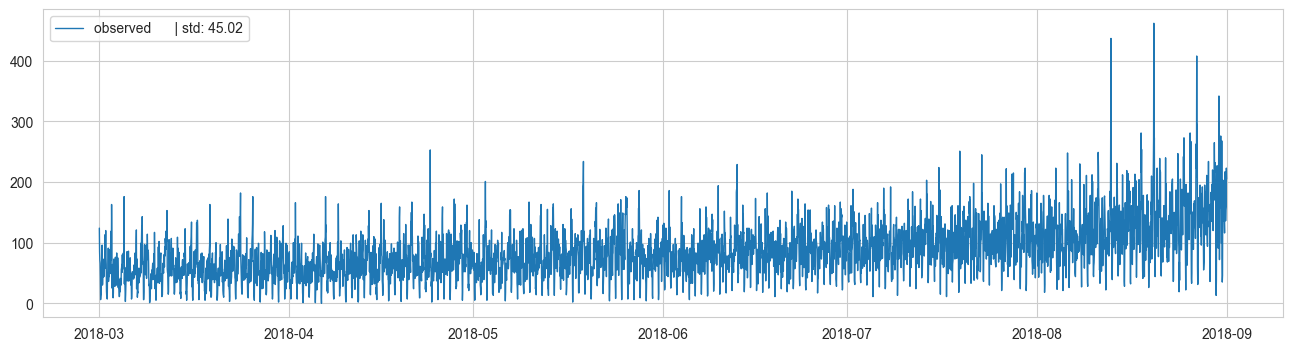

In [15]:
plt.figure(figsize=(16, 4))
plt.plot(data['num_orders'], linewidth=1, label=f'{"observed":<13} | std: {data["num_orders"].std():.2f}')
plt.legend()
plt.show()

На глаз заметен небольшой тренд на повышение значений и увеличение дисперсии. Стандартное отклонение составляет 45.02.  
Так же на графике заметны выбросы, самые заметные из них - в последних двух третях августа.

Декомпозируем временной ряд на 3 составляющих: тренд, сезонность и остаток

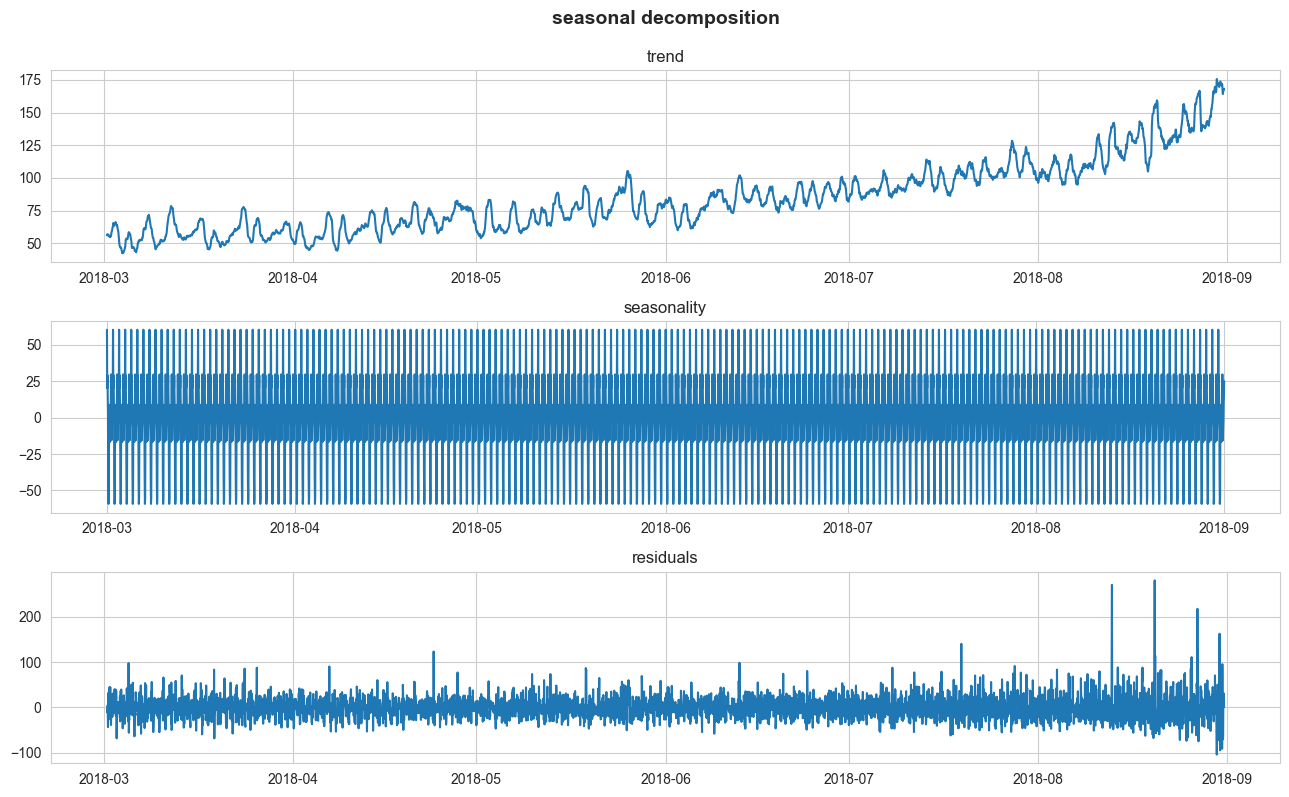

In [16]:
decomposed(data)

Видим устойчивый тренд на увеличение.  
Остатки имеют несколько более высокую дисперсию на краях графика, особенно на правом. В середине графика разброс остатков не такой большой.  
В данных хорошо наблюдается сезонная составляющая. Рассмотри ее на меньшем масштабе - в один месяц

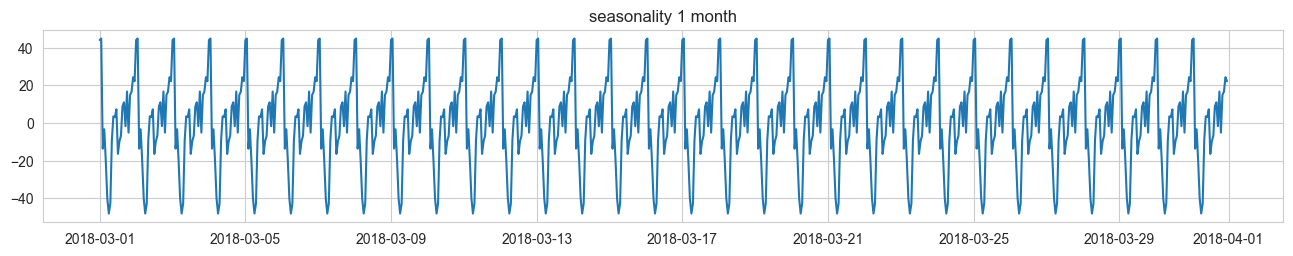

In [17]:
plt.figure(figsize=(16, 2.5))
plt.plot(seasonal_decompose(data[:'2018-03']).seasonal)
plt.title('seasonality 1 month')
plt.show()

Наблюдаем сезонность, равную 24 часам.

Если вернуться к графику с трендом, то на нем заметны повторяющиеся колебания - скорее всего их можно объяснить более длинным сезонным периодом, равным неделе.  
Отобразим график с трендом за первые полтора месяца и отметим каждое начало понедельника зеленой вертикальной линией. Красными черточками отобразим усредненное количество поездок за каждый день.

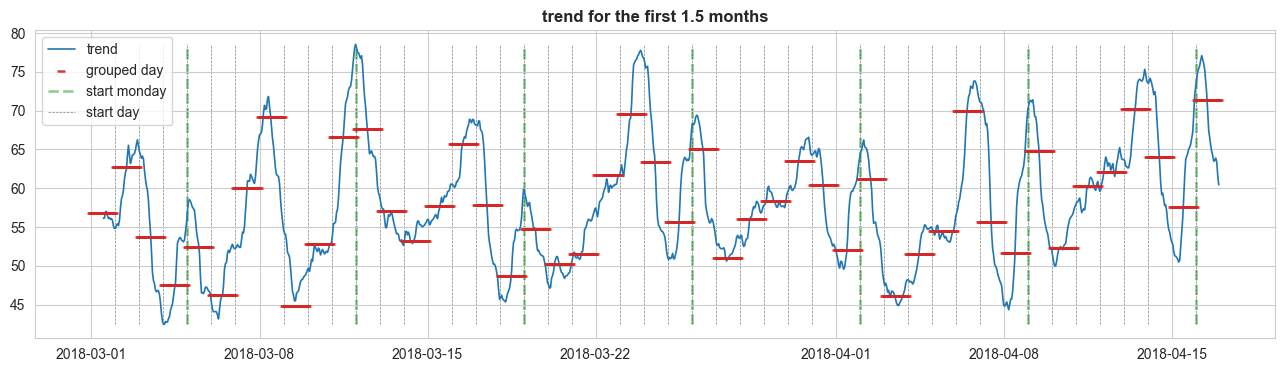

In [18]:
# Вспомогательная табличка, с помощью которой мы отберем индексы каждого начала понедельника
# и вычислим среднее значение за каждый день
data_temp = data.copy()
data_temp['monday'] = data_temp.index.weekday.isin([0]) * 1
data_temp['hour_0'] = data_temp.index.hour.isin([0]) * 1
data_temp['monday_start'] = data_temp['monday'] * data_temp['hour_0']
data_temp['num_order_day_mean'] = data_temp['num_orders'].resample('1D').mean()
data_temp['num_order_day_mean'] = data_temp['num_order_day_mean'].fillna(method='ffill')


def day_group_plot(data, obs, title=None, obs_title='observed'):
    plt.figure(figsize=(16, 4))
    plt.plot(obs, linewidth=1.2, label=obs_title)
    plt.scatter(x=data.index, y=data['num_order_day_mean'], color='C3', linewidths=1.8, alpha=.9, marker='_', label='grouped day').set_zorder(10)
    plt.vlines(x=data.query('monday_start > 0').index, ymin=obs.min(), ymax=obs.max(), color='C2', alpha=.5, linestyle='dashed', label='start monday', linewidth=2).set_zorder(0)
    plt.vlines(x=data.query('hour_0 > 0').index, ymin=obs.min(), ymax=obs.max(), color='black', alpha=.5, linestyle='dashed', label='start day', linewidth=.5).set_zorder(0)
    plt.legend(loc='upper left')
    plt.title(title, fontweight='bold')
    plt.show()


day_group_plot(data_temp[:'2018-04-16'], seasonal_decompose(data['num_orders']).trend[:'2018-04-16'], title='trend for the first 1.5 months', obs_title='trend')

Это напоминает недельный цикл. Пики почти всегда приходятся на понедельник и пятницу; а в воскресенье и вторник наблюдаются провалы, где-то больше, где-то меньше.  

То же самое отобразим поверх изначальных наблюдений.  
В этом случае бросаются в глаза всплески в первый час понедельника. Не исключено, что эти выбросы обусловлены ошибками при сборе данных во время начала новой недели.
Более низкие пики наблюдаются в начале каждых суток - они отмечены тонкими черными вертикальными линиями сетки

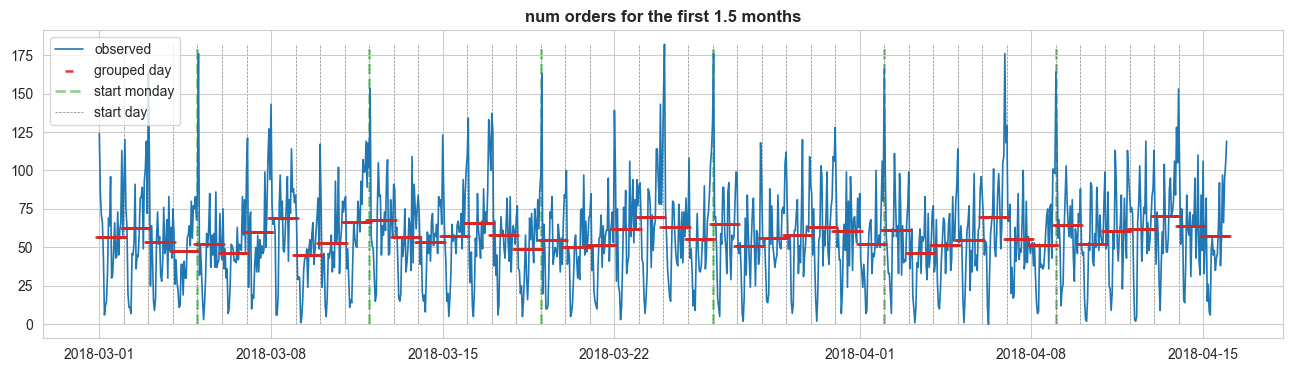

In [19]:
day_group_plot(data_temp[:'2018-04-15'], data_temp[:'2018-04-15']['num_orders'], 'num orders for the first 1.5 months')

Теперь рассмотри последние 3 недели датасета

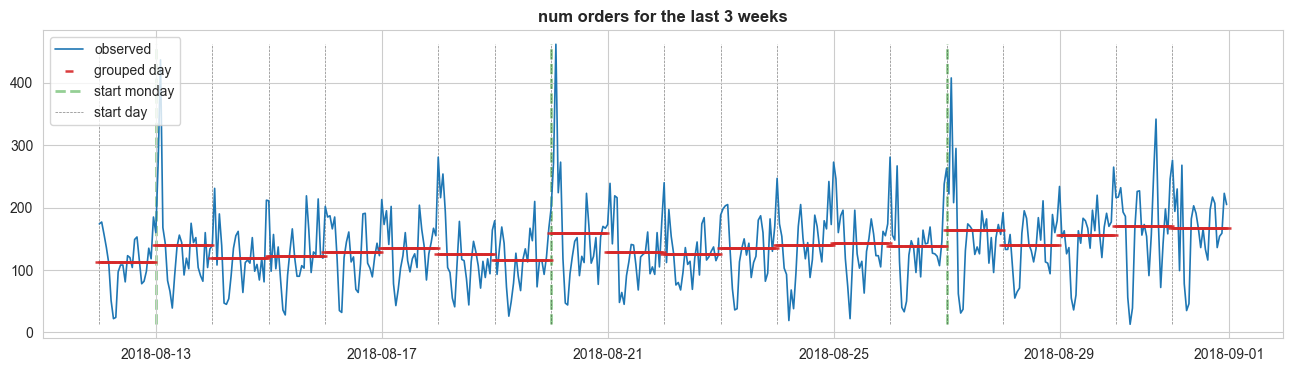

In [20]:
day_group_plot(data_temp['2018-08-12':], data_temp['2018-08-12':]['num_orders'], 'num orders for the last 3 weeks')

Видим аналогичные заметные всплески каждое начало новой недели. Колебания усредненных поездок по дням на этом участке графика не так заметны.

Отобразим на графике **скользящее среднее** и **скользящее стандартное отклонение** с окном, равным одному циклу - 24 измерения.

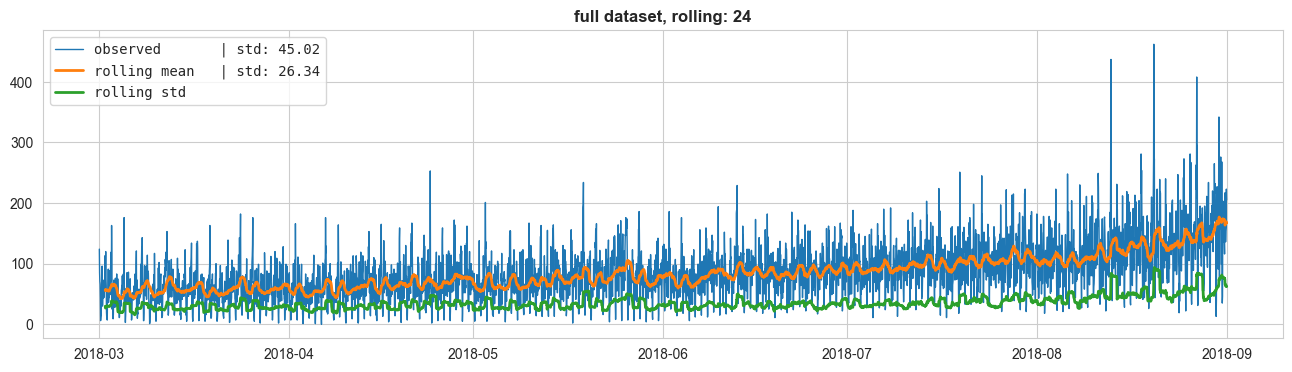

In [21]:
plot_roll(data['num_orders'], 'full dataset', rolling=24)

Использование скользящего среднего способно в значительной мере сгладить колебания, стандартное отклонение значений при этом уменьшается с 45 до 26. Скользящее среднее так же делает долгосрочный тренд более заметным.  
Скачки на графике скользящего стандартного отклонения говорят о непостоянстве дисперсии, даже сглаженных данных. Это так же связано с недельной сезонностью.

Сгруппируем данные по нескольким признакам, а именно - **час**, **день недели**, **порядковый номер дня в месяце** и **номер месяца**. Найдем среднее для каждого значения признака

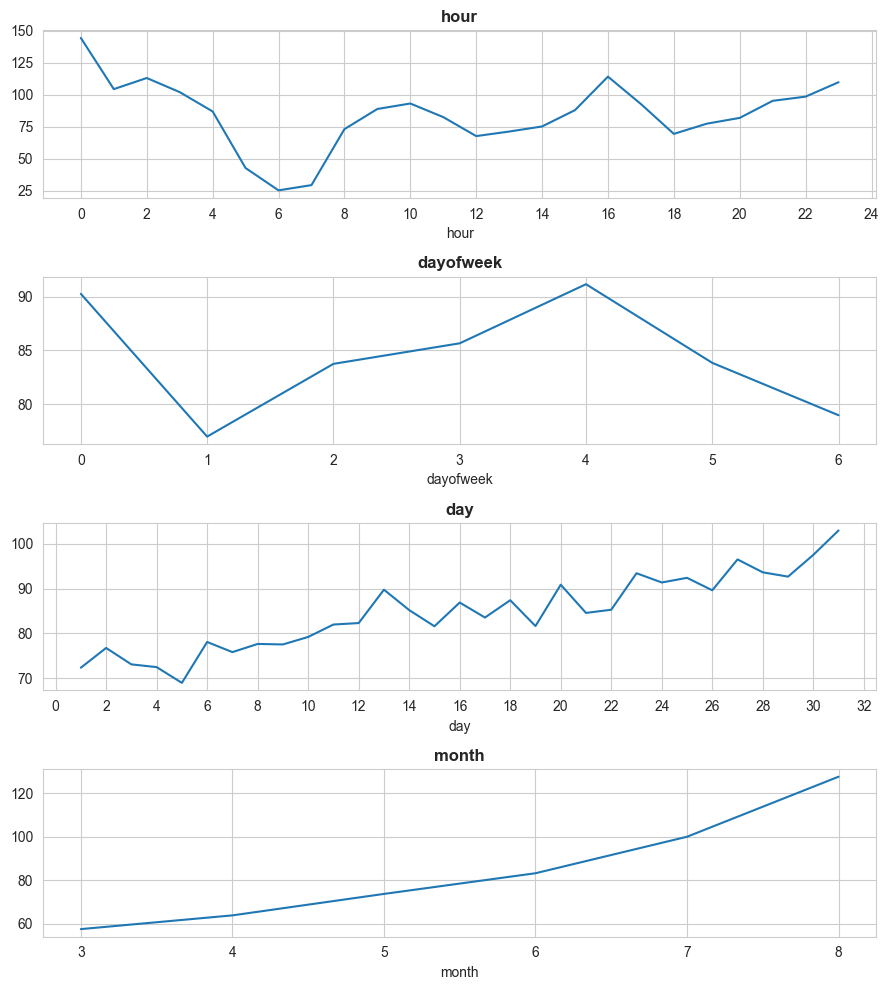

In [22]:
# Добавляем в таблицу признаки, сформированные на основе даты и времени
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['day'] = data.index.day
data['month'] = data.index.month


# функция для отрисовки графиков
def group_plot(data, features):
    count_plot = len(features)
    fig, axes = plt.subplots(count_plot, 1, figsize=(9, count_plot * 2.5))
    for ax, feature in zip(axes.flat, features):
        data_group = data.groupby(feature)['num_orders'].mean()
        data_group.plot(ax=ax)
        ax.locator_params(axis='x', nbins=data_group.nunique())
        ax.set_title(feature, fontweight='bold')
        ax.set_ylabel('')
    plt.tight_layout()



group_plot(data, ['hour', 'dayofweek', 'day', 'month'])

1. Усреднив все значения по каждому часу видим, что с начала суток до 6 часов наблюдается сокращение количества поездок. Затем идет возрастание до 10 часов, небольшой спад до 12, и затем плавный рост до 16. Далее идет последнее падение до 18 часов и затем плавный рост до полуночи.
2. В рамках недели наблюдается рост в понедельник и пятницу. Падения характерны для вторника и воскресенья
3. От начала к концу месяца прослеживается увеличение количества заказов.
4. От месяца к месяцу тренд на увеличение так же заметен.

Первые три параметра мы будем использовать в качестве признаков для моделей регрессии. Последний признак - номер месяца, использовать будет не совсем корректно. Так как если попытаться заглянуть за рамки представленного датасета, то с окончанием лета и наступлением осени количество поездок вполне может измениться, что негативно скажется на точности предсказаний. Учитывать месяц можно было бы, если измерения в датасете перекрывали бы хотя бы пару годовых сезонов.  
Поэтому признак `month` мы удалим.

In [23]:
data = data.drop('month', axis=1)

**Вывод:** при первичном анализе удалось выяснить следующее:
- данные имеют тренд на увеличение
- наблюдаются сезонности: короткая **дневная**, средняя **недельная** и длинная **месячная**
- данные не обладают постоянством дисперсии и имеют выбросы

Так же были сформированы три признака: **час**, **день недели** и **порядковый номер дня в месяце** для использования в моделях регрессии.
<br><br>

В нашем ряду среднее значение и стандартное отклонение с течением времени изменяются. По этим факторам можно сделать вывод, что ряд **нестационарен**. Проверим это с помощью двух статистических тестов: 
1. тест Дики-Фуллера:
    - $H0$ - ряд не стационарный
    - $H1$ - ряд стационарный
3. тест Квятковского, Филлипса, Шмидта и Шина или (KPSS)
    - $H0$ - ряд стационарный
    - $H1$ - ряд не стационарный
  
Заметим, что в этих двух тестах нулевые гипотезы являются противоположными

In [24]:
# Dickey-Fuller:
# H0 - ряд не стационарный
# H1 - ряд стационарный

# KPSS
# H0 - ряд стационарный
# H1 - ряд не стационарный

def adf_kpss(data, alpha=.05):
    p_value = adfuller(data)[1]
    print(f'Dickey-Fuller: p-value = {p_value:.4f}')
    if p_value > alpha:
        print('Недостаточно оснований отвергнуть нулевую гипотезу о нестационарности ряда')
    else:
        print('Отвергаем нулевую гипотезу о нестационарности ряда\n')

    p_value = kpss(data)[1]
    print(f'KPSS: p-value = {p_value:.4f}')
    if p_value > alpha:
        print('Недостаточно оснований отвергнуть нулевую гипотезу о стационарности ряда')
    else:
        print('Отвергаем нулевую гипотезу о стационарности ряда')

In [25]:
adf_kpss(data['num_orders'])

Dickey-Fuller: p-value = 0.0289
Отвергаем нулевую гипотезу о нестационарности ряда

KPSS: p-value = 0.0100
Отвергаем нулевую гипотезу о стационарности ряда


Применение статистического теста Дики-Фуллера вернуло значение p-value = 0.0289, этого достаточно (при уровне значимости 5%), чтобы отвергнуть нулевую гипотезу о **НЕстационарности** ряда.  
Тест KPSS вернул p-value = 0.0100, что отвергает нулевую гипотезу о **стационарности** ряда.

Результаты тестов получились противоположными. Иными словами у нас есть основания считать временной ряд нестационарным.

Применим к данным **дифференцирование** со сдвигом на одно измерение и проведем статистические тесты заново

In [26]:
adf_kpss(data['num_orders'].diff().dropna())

Dickey-Fuller: p-value = 0.0000
Отвергаем нулевую гипотезу о нестационарности ряда

KPSS: p-value = 0.1000
Недостаточно оснований отвергнуть нулевую гипотезу о стационарности ряда


В данном случае результаты тестов совпадают. При единичном дифференцировании у нас недостаточно оснований считать ряд нестационарным.  

Посмотрим на график дифференцированного ряда, а так же декомпозируем его на составляющие.

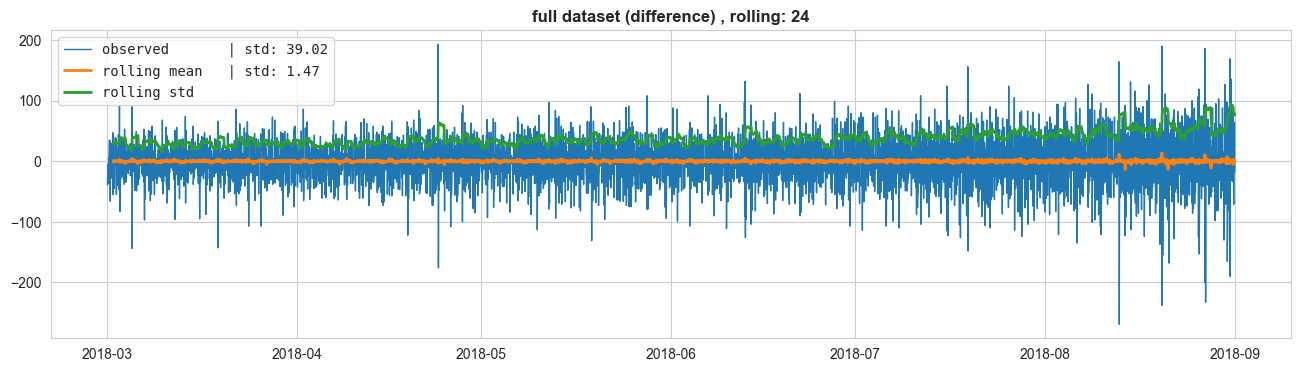

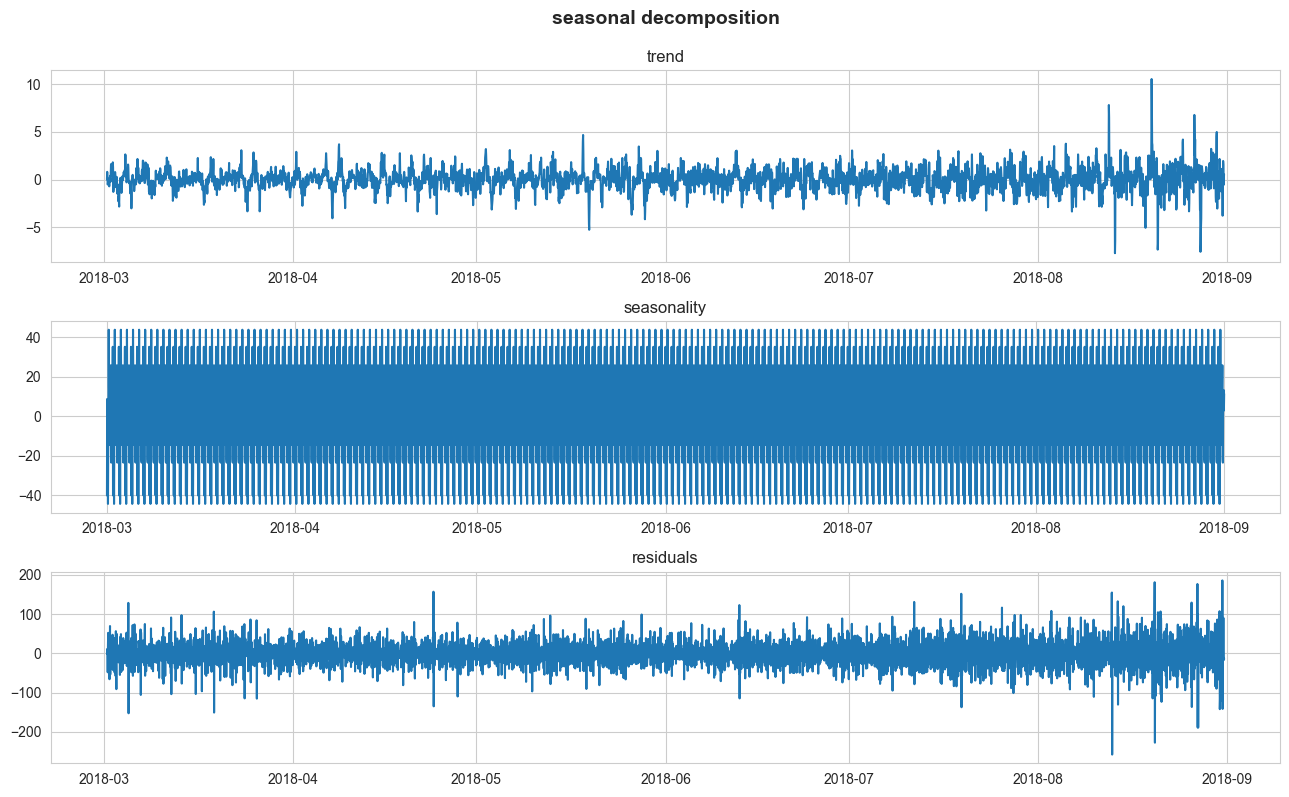

In [27]:
plot_roll(data['num_orders'].diff(), 'full dataset (difference) ', rolling=24)
print()
decomposed(data['num_orders'].diff().dropna())

На графиках видно, что дифференцирование убрало восходящий тренд, выравняло среднее значение и несколько уменьшило стандартное отклонение с 45 до 39.

**Вывод:** применение дифференцирования со сдвигом на один шаг избавляет временной ряд от нестационарности.
<br><br>

Теперь рассмотрим графики автокорреляции и частичной автокорреляции

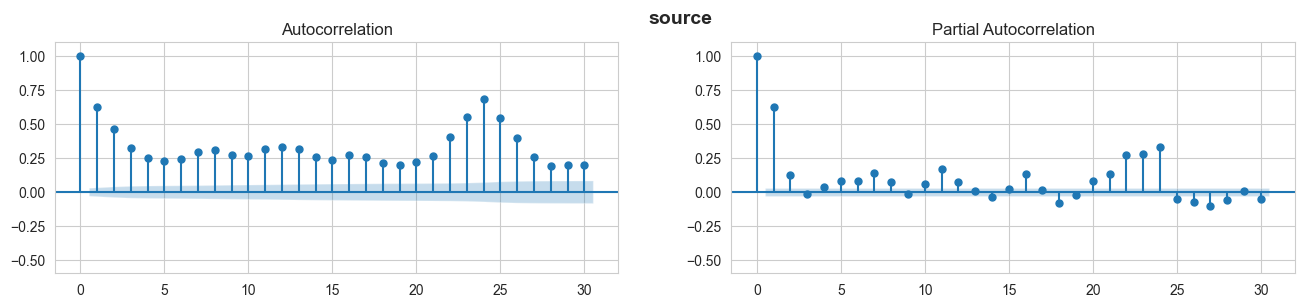

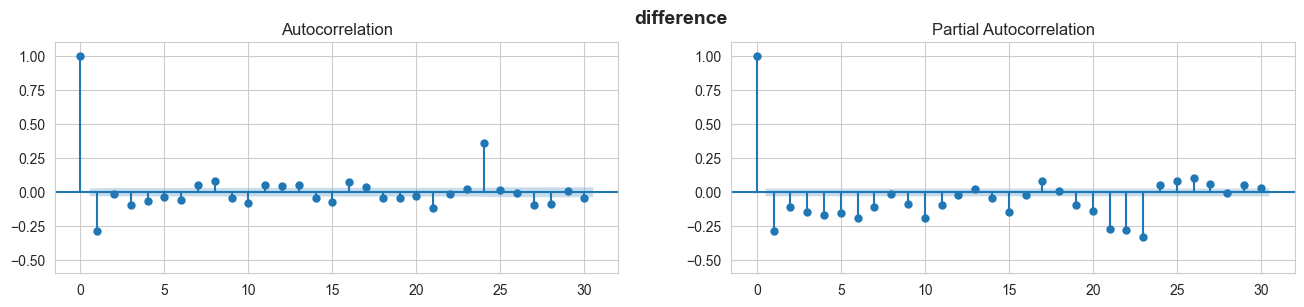

In [28]:
plot_acf_pacf(data['num_orders'], title='source', lags=30)
plot_acf_pacf(data['num_orders'].diff().dropna(), title='difference', lags=30)

- На графике автокорреляции для исходного ряда (верхний левый) мы видим, что статистически значимое влияние на значение оказывают все задержки из суточного цикла, что так же свидетельствует о наличие тренда. Наиболее сильное влияние имеют следующие лаги - 1, 2, 3, 8, 11, 12, 13, 22, 23, 24.
- На следующем графике уже частотной автокорреляции исходного ряда (правый верхний), наблюдается существенное влияние только следующих задержек - 1, 2, 22, 23, 24.
- На двух нижних графиках представлены автокорреляции для дифференцированного ряда. Они нам пригодятся для подбора параметров ($p,d,q$) в первом приближении для моделей семейства ARMA. На графике автокорреляции видно, что значительное влияние на измерение (в рамках суточной сезонности) оказывает только 1 и 24 задержки.

Рассмотрим те же графике, но на большем масштабе, для оценки влияния между сезонами.

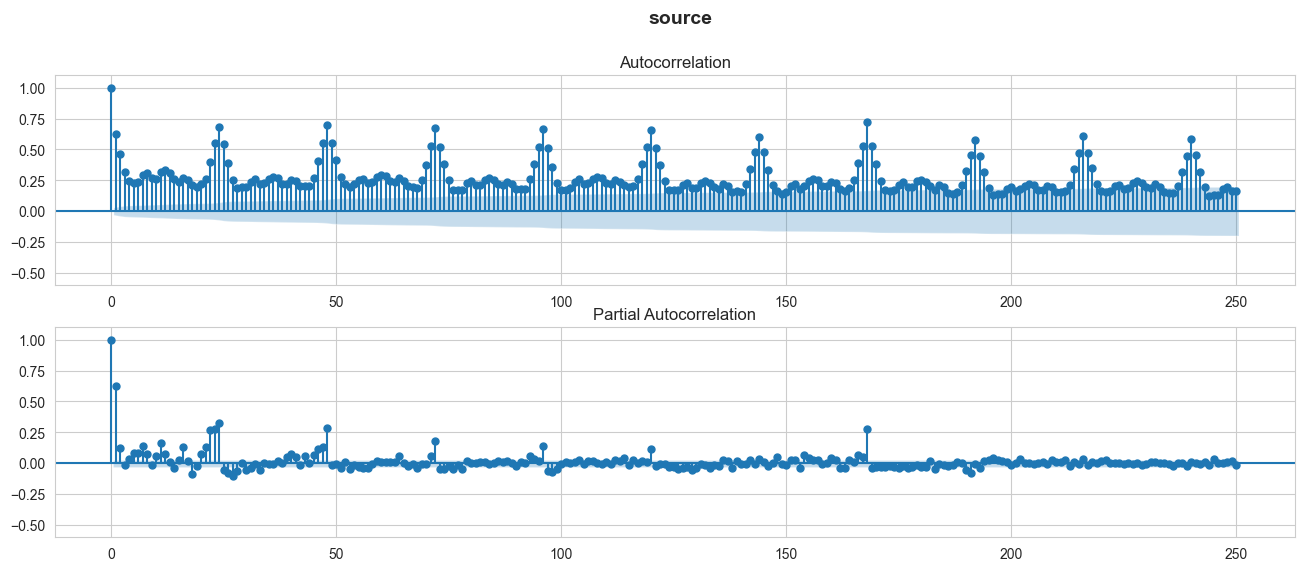

In [29]:
plot_acf_pacf(data['num_orders'], title='source', lags=250, vertical=True)

Автокорреляция исходного ряда говорит о том, что на текущее измерение в рамках нескольких сезонов наиболее сильно влияют измерения, сделанные в начале и конце каждого предыдущего дневного цикла. На графике частичной автокорреляции мы так же видим, что почти каждое 24 измерение влияет на исходное, разве что влияние 144 измерения (6 сезон) не выражено. влияние 168 лага (7 сезон) хорошо прослеживается, а все что произошло более недели назад не особо существенно.

Графики автокорреляции на большем масштабе для дифференцированного ряда мы рассмотрим ниже, во время подбора параметров модели ARIMA. Дифференцирование ряда для универсальных регрессионных моделей мы производить не будем, так как небольшая нестационарность для них не проблема. Тестирование так же показало, что дифференцирование не добавляет точности на данных моделях в рамках нашего датасета. 

В качестве одних из признаков для регрессионных моделей мы будем использовать задержки измерений. Ограничимся максимум семью сезонами (1 неделей). Отберем наиболее значимые, не выходящие за порог доверительного интервала, параметр $alpha$ подберем экспериментально по графику, что бы отбросить более половины лагов. Отобранные задержки отметим на графике точками зеленого цвета.  
Остановимся на $alpha= 10^{-6}$. Сохраним номера лагов в список, который потом применим для создания признаков.

In [30]:
def important_lags(data, lag_max=30, alpha=.05):
    acf_result = acf(data, nlags=lag_max, alpha=alpha)
    confidence_interval = acf_result[1]
    confidence_interval = abs(confidence_interval[:, 0] - confidence_interval[:, 1]) / 2
    imp_lags = pd.DataFrame({'acf': abs(acf_result[0]), 'ci': confidence_interval})
    imp_lags = imp_lags.drop(0).query('acf > ci')
    return imp_lags['acf']

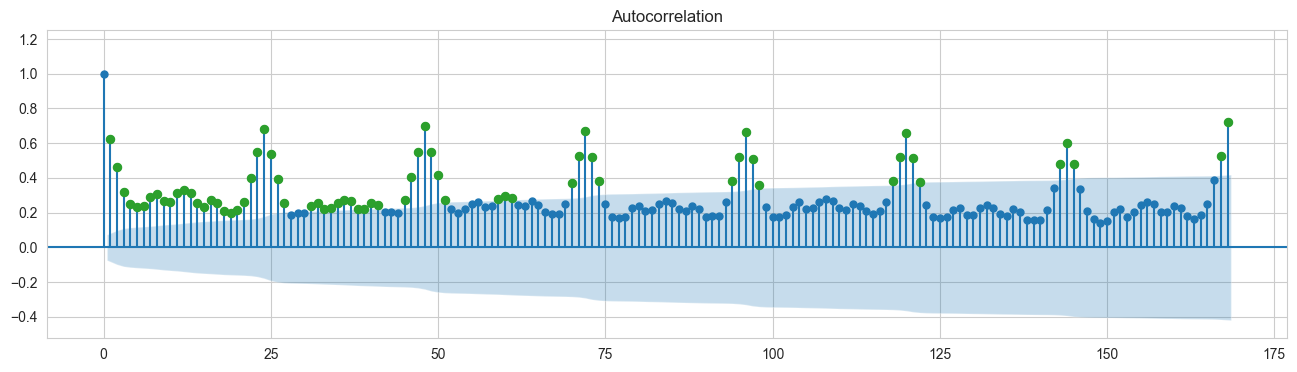

Количество отобранных задержек: 68


In [31]:
alpha=1e-6

important_lags_series = important_lags(data['num_orders'], lag_max=168, alpha=alpha)
important_lags_list = important_lags_series.index

fig, ax = plt.subplots(figsize=(16, 4))
plot_acf(data['num_orders'], ax=ax, auto_ylims=True, lags=168, alpha=alpha)
ax.scatter(x=important_lags_list, y=important_lags_series, linewidths=.8, color='C2').set_zorder(10)
plt.show()

print('Количество отобранных задержек:', len(important_lags_list))

Успешно сформирован список с номерами задержек, оказывающими наибольшее влияние на измерение. На основе него будут сформированы дополнительные признаки для регрессионных моделей.

Так же в качестве признака добавим скользящее среднее с шириной окна в 3 измерения с отставанием на 1 такт, для избежания утечки целевого признака.

In [32]:
# создание признаков, содержащих лаги
for lag in important_lags_list:
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

data['rolling_mean'] = data['num_orders'].shift().rolling(3).mean()


data.dropna().head()

num_orders  hour  dayofweek  day  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-08 00:00:00         143     0          3    8   94.0  127.0  108.0   
2018-03-08 01:00:00          78     1          3    8  143.0   94.0  127.0   
2018-03-08 02:00:00          65     2          3    8   78.0  143.0   94.0   
2018-03-08 03:00:00          68     3          3    8   65.0   78.0  143.0   
2018-03-08 04:00:00          60     4          3    8   68.0   65.0   78.0   

                     lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  \
datetime                                                                        
2018-03-08 00:00:00   76.0   50.0   99.0   48.0   46.0   51.0    43.0    55.0   
2018-03-08 01:00:00  108.0   76.0   50.0   99.0   48.0   46.0    51.0    43.0   
2018-03-08 02:00:00  127.0  108.0   76.0   50.0   99.0   48.0    46.0    51.0   
2018-03-08 03:00:00   94.0  127.0  108.0   76.0   50.0   99.0    48.0    46.0   
2018-03-08 04:00:00  143.0   94.0  127.0  108.0   76.0   50.0    99.0    48.0   

                     lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  \
datetime                                                                      
2018-03-08 00:00:00    34.0    58.0    34.0    50.0    38.0    17.0    19.0   
2018-03-08 01:00:00    55.0    34.0    58.0    34.0    50.0    38.0    17.0   
2018-03-08 02:00:00    43.0    55.0    34.0    58.0    34.0    50.0    38.0   
2018-03-08 03:00:00    51.0    43.0    55.0    34.0    58.0    34.0    50.0   
2018-03-08 04:00:00    46.0    51.0    43.0    55.0    34.0    58.0    34.0   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  lag_25  \
datetime                                                                      
2018-03-08 00:00:00    10.0    73.0    66.0    24.0   121.0   100.0    47.0   
2018-03-08 01:00:00    19.0    10.0    73.0    66.0    24.0   121.0   100.0   
2018-03-08 02:00:00    17.0    19.0    10.0    73.0    66.0    24.0   121.0   
2018-03-08 03:00:00    38.0    17.0    19.0    10.0    73.0    66.0    24.0   
2018-03-08 04:00:00    50.0    38.0    17.0    19.0    10.0    73.0    66.0   

                     lag_26  lag_27  lag_31  lag_32  lag_33  lag_34  lag_35  \
datetime                                                                      
2018-03-08 00:00:00    81.0    58.0    52.0    42.0    63.0    40.0    42.0   
2018-03-08 01:00:00    47.0    81.0    51.0    52.0    42.0    63.0    40.0   
2018-03-08 02:00:00   100.0    47.0    48.0    51.0    52.0    42.0    63.0   
2018-03-08 03:00:00   121.0   100.0    83.0    48.0    51.0    52.0    42.0   
2018-03-08 04:00:00    24.0   121.0    58.0    83.0    48.0    51.0    52.0   

                     lag_36  lag_37  lag_38  lag_39  lag_40  lag_41  lag_45  \
datetime                                                                      
2018-03-08 00:00:00    41.0    48.0    51.0    52.0    25.0    10.0    49.0   
2018-03-08 01:00:00    42.0    41.0    48.0    51.0    52.0    25.0    30.0   
2018-03-08 02:00:00    40.0    42.0    41.0    48.0    51.0    52.0    36.0   
2018-03-08 03:00:00    63.0    40.0    42.0    41.0    48.0    51.0     7.0   
2018-03-08 04:00:00    42.0    63.0    40.0    42.0    41.0    48.0    10.0   

                     lag_46  lag_47  lag_48  lag_49  lag_50  lag_51  lag_59  \
datetime                                                                      
2018-03-08 00:00:00    36.0    75.0    42.0    47.0    72.0    42.0    37.0   
2018-03-08 01:00:00    49.0    36.0    75.0    42.0    47.0    72.0    58.0   
2018-03-08 02:00:00    30.0    49.0    36.0    75.0    42.0    47.0    45.0   
2018-03-08 03:00:00    36.0    30.0    49.0    36.0    75.0    42.0    59.0   
2018-03-08 04:00:00     7.0    36.0    30.0    49.0    36.0    75.0    37.0   

                     lag_60  lag_61  lag_70  lag_71  lag_72  lag_73  lag_74  \
datetime                                                 

Признаки успешно добавлены.  

Проверим наличие мультиколлинерности между фичами. Отобразим табличку, где в начале будут пары признаков с наибольшей корреляцией.

In [33]:
corr_sort(data.corr(), 10)

Мультиколлинеарности в признаках не наблюдается.  
Отобразим еще одну табличку, где будут наиболее коррелирующие с таргетом признаки.

In [34]:
target_corr(data.corr(), 'num_orders', 10)

Наиболее сильно коррелируют с количеством заказов признаки на основе задержек, а именно - 168, 48, 120.

**Вывод:** в датасет добавлены новые признаки на основе отобранных номеров задержек, скользящего среднего, а так же признаков, содержащих час, день недели и порядковый номер дня в месяце. Эффекта мултиколлинеарности между признаками не наблюдается.

## Обучение

In [35]:
RANDOM_STATE = 42
target = 'num_orders'

# Отделяем таргет от входных признаков
X = data.drop(target, axis=1)
y = data[target]

# Разделяем датасет на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

# Удаляем начало тренировочного датасета с пропусками, которые образовались из за того, 
# что в качестве признаков мы используем лаги
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

# Формируем список признаков, которые можно отнести к ранговым категориальным. 
# В нашем случае они уже представлены в виде чисел, так что в обработке не нуждаются
no_scale_columns = ['hour', 'dayofweek', 'day']
# Оставшиеся признаки необходимо масштабировать, определяем для них отдельный список
scale_columns = [x for x in list(X_train.columns) if x not in no_scale_columns]

Отобразим на графике границы тренировочного и тестового датасетов

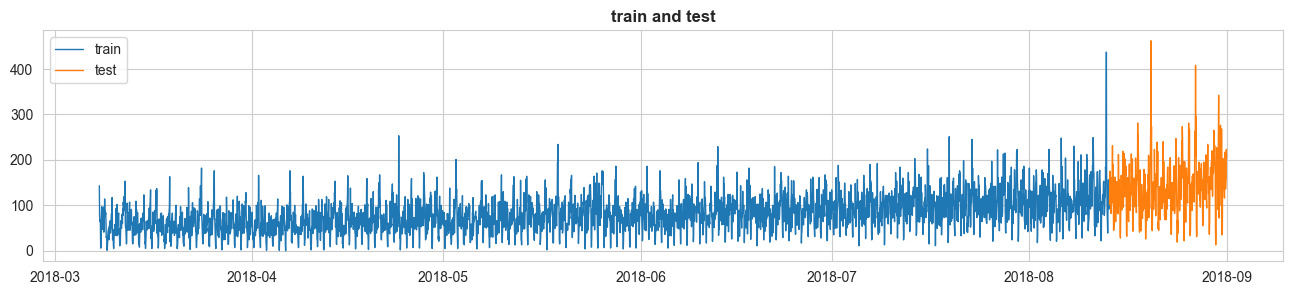

In [36]:
plt.figure(figsize=(16, 3))
plt.plot(y_train, linewidth=1, label='train')
plt.plot(y_test, linewidth=1, label='test')
plt.legend(loc='upper left')
plt.title('train and test', fontweight='bold')
plt.show()

In [37]:
# Объявим датафрейм, в который будем заносить результаты протестированных моделей
rating_model = pd.DataFrame(columns=['Search params (sec)', 'Predict (sec)', 'RMSE (cv) train', 'Residuals mean', 'Residuals std'])

In [38]:
# Пайплайн для масштабирования количественных признаков. 
data_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), scale_columns)    
], remainder= 'passthrough')

In [39]:
# Функция автоматизированного подбора гиперпараметров
def optuna_search_cv(estimator, param_distributions, X_train, y_train, n_trials=30):
    estimator = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', estimator)])

    # Подбор параметров и кросс-валидацию будем осуществлять с помощью байесовской оптимизации
    # из модуля Optuna
    optuna_search = OptunaSearchCV(
        estimator, 
        param_distributions, 
        cv=TimeSeriesSplit(n_splits=8),
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_trials=n_trials
    )

    # Подбор параметров и кросс-валидация
    start = time.time()
    optuna_search.fit(X_train, y_train)
    search_time = time.time() - start


    # Получаем название модели
    model_name = optuna_search.best_estimator_[1].__class__.__name__
    # Заносим в табличку метрику на кросс-валидации и время подбора параметров
    rating_model.loc[model_name, 'RMSE (cv) train'] = round(optuna_search.best_score_ * -1, 4)
    rating_model.loc[model_name, 'Search params (sec)'] = round(search_time, 4)


    # функция возвращает объект OptunaSearchCV с обученной лучшей моделью
    return optuna_search

In [40]:
# Функция для вывода параметров лучшей модели
def optuna_result(optuna_search, X_train, y_train, view_imp=True):

    # Получаем название текущей модели
    model_name = optuna_search.best_estimator_[1].__class__.__name__

    
    # Выводим список лучших гиперпараметров если список с ними не пуст
    if not optuna_search_dummy.best_params_:
        print(f'{model_name} best parameters:')
        for i, j in optuna_search.best_params_.items():
            print(f'{i}: {j}')

    
    # Выполняем предсказание на тренировочной выборке для расчета остатков и
    # замера времени предсказания
    start = time.time()
    y_pred = optuna_search.predict(X_train)
    predict_time = time.time() - start

    # Список предсказания преобразуем в Series, где в качестве индекса восстановим дату и время
    y_pred = pd.Series(y_pred, index=X_train.index)

    # Подсчет остатков
    resid = y_train - y_pred

    # Запись результатов в таблицу
    rating_model.loc[model_name, 'Predict (sec)'] = round(predict_time, 4)
    rating_model.loc[model_name, 'Residuals mean'] = round(resid.mean(), 4)
    rating_model.loc[model_name, 'Residuals std'] = round(resid.std(), 4)
    
    
    # Выводим сформированную табличку с параметрами времени и метриками
    display(rating_model.loc[[model_name]])

    # Графики с предсказаниями модели и анализом остатков
    analysis_results_plot(y_train, y_pred, title=model_name, view_last_segment=600)

    # График важности признаков
    if view_imp:
        print('\n')
        feature_importances_plot(optuna_search)

        
    # Для отладки
    # display(optuna_search.trials_dataframe())

In [41]:
# Функция для отрисовки графика с важностью признаков
def feature_importances_plot(optuna_search):
    model_name = optuna_search.best_estimator_[1].__class__.__name__
    
    if model_name in ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet']:
        coefs = optuna_search.best_estimator_[1].coef_
    else:
        coefs = optuna_search.best_estimator_[1].feature_importances_

    coefs = pd.DataFrame({'coef': coefs}, optuna_search.best_estimator_[0].get_feature_names_out())
    coefs['abs'] = coefs['coef'].apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop('abs', axis=1).query('coef != 0')
    coefs_top = coefs.head(15)

    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(x=coefs_top['coef'], y=coefs_top.index, ax=ax)
    ax.set_title(f'feature importances (total: {coefs.shape[0]})', fontweight='bold')
    plt.show()

In [42]:
# Функция для отрисовки графиков с предсказаниями модели и анализом остатков
def analysis_results_plot(true, pred, title=None, view_last_segment=0):
    resid = true - pred
    resid_roll = resid.rolling(24).mean()
    
    fig, ax = plt.subplots(2, 1, figsize=(16, 7))
    plt.suptitle(title, fontsize=14, fontweight='bold', x=.516, y=.99)

    title_obs = ''
    if 0 < view_last_segment < true.index.size:
        ax[0].set_xlim(xmin=true.index[-view_last_segment], xmax=true.index[-1])
        ax[1].set_xlim(xmin=true.index[-view_last_segment], xmax=true.index[-1])
        title_obs = f' (last {view_last_segment} observations displayed)'
    
    ax[0].plot(true, label='true')
    ax[0].plot(pred, label='pred')
    ax[0].set_title('observed and predictions' + title_obs, fontweight='bold')
    ax[0].legend(loc='upper left')
    
    ax[1].plot(resid, color='C3', label=f'residuals')
    ax[1].plot(resid_roll, color='C2', label=f'residuals rolling')
    ax[1].set_title('residuals', fontweight='bold')
    ax[1].legend(loc='upper left')
    plt.show()

    
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    sns.histplot(resid, kde=True, bins=30, legend=True, ax=ax[0])
    ax[0].axvline(x=resid.median(), color='black', alpha=.6, label=f'{"median:":<7} {resid.median():.2f}')
    ax[0].axvline(x=resid.mean(),   color='black', alpha=.6, label=f'{"mean:":<7} {resid.mean():.2f}', linestyle='dashed')
    ax[0].axvline(x=0, alpha=0, label=f'{"std:":<7} {resid.std():.2f}')
    ax[0].axvline(x=0, alpha=0, label=f'{"min:":<7} {resid.min():.2f}')
    ax[0].axvline(x=0, alpha=0, label=f'{"max:":<7} {resid.max():.2f}')
    ax[0].set_title('histogram of residuals')
    ax[0].legend(prop={'family': 'monospace'})

    plot_acf(resid, ax=ax[1], lags=100, auto_ylims=True, title='autocorrelation of residuals')
    
    plt.show()

In [43]:
# отключение вывода предупреждающих сообщений
warnings.filterwarnings('ignore')

### Constant model - **DummyRegressor**

В качестве начальной точки отсчета для оценки моделей применим константную модель **DummyRegressor**; для каждого объекта в качестве предсказания она всегда выдает среднее значение таргета. Оценим метрику RMSE на крсс-валидации.

DummyRegressor best parameters:


Search params (sec) Predict (sec) RMSE (cv) train  \
DummyRegressor              0.0861         0.003         39.4822   

               Residuals mean Residuals std  
DummyRegressor           -0.0       38.6833

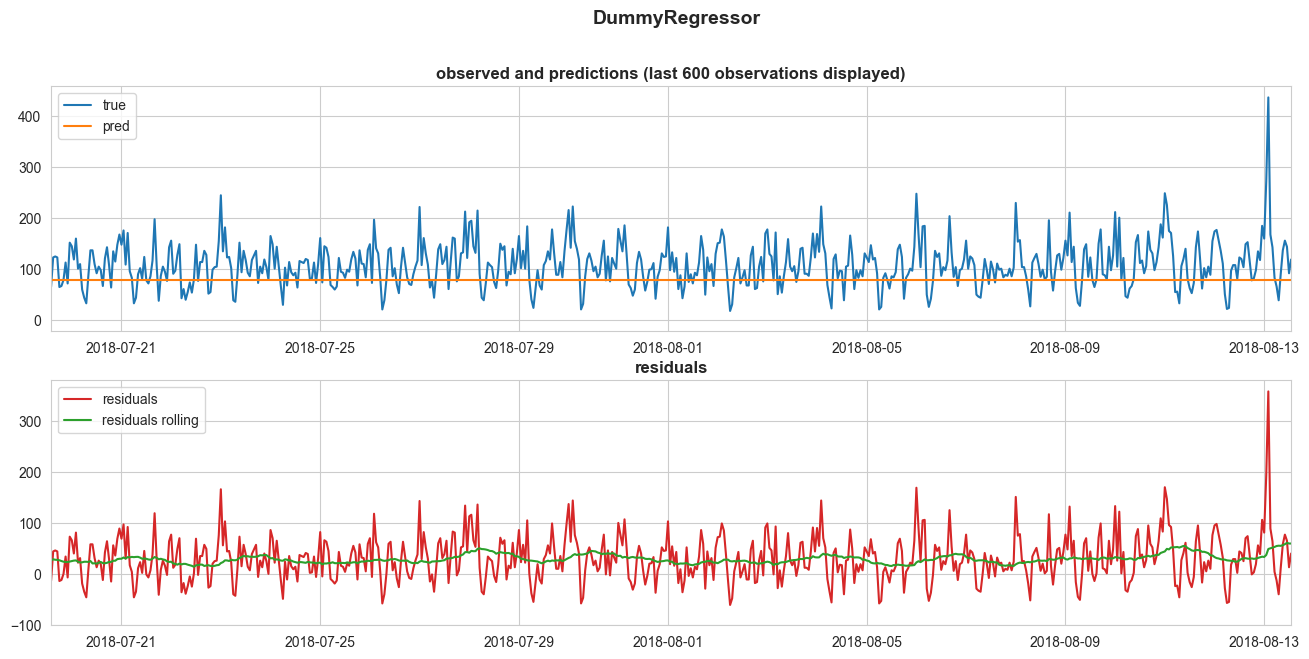

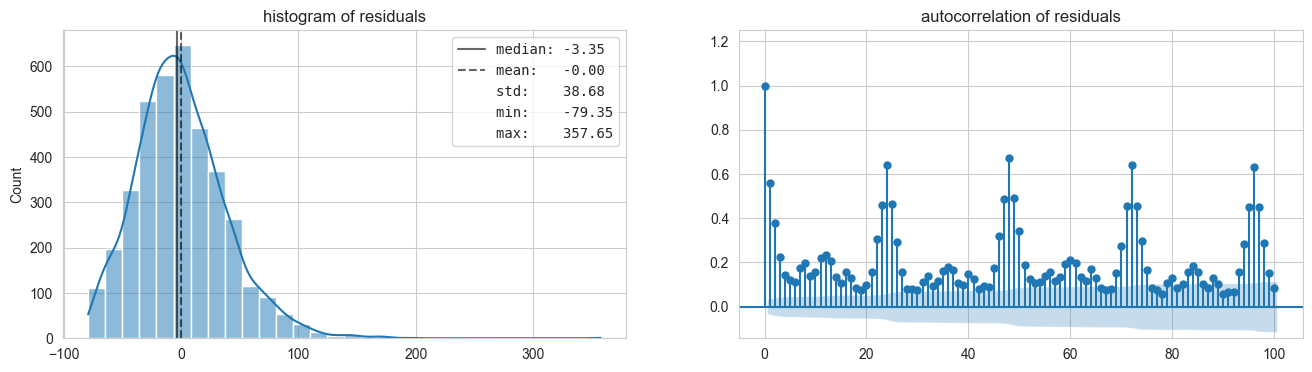

In [44]:
# Список параметров
param_distributions = {
}

# Подбор параметров
optuna_search_dummy = optuna_search_cv(
    DummyRegressor(strategy='mean'), 
    param_distributions,
    X_train, y_train, 
    n_trials=1 # количество итераций равно 1, так как здесь нет необходимости подбирать гиперпараметры
)

# Вывод результатов
optuna_result(optuna_search_dummy, X_train, y_train, view_imp=False)

**Вывод:** не удивительно, что при таком подходе осталось огромная автокорреляция остатков. Нами получено начальное значение метрики RMSE, для проверки моделей на адекватность.

### **LinearRegression**

LinearRegression best parameters:


Search params (sec) Predict (sec) RMSE (cv) train  \
LinearRegression              0.1687         0.004         21.9532   

                 Residuals mean Residuals std  
LinearRegression           -0.0       20.7566

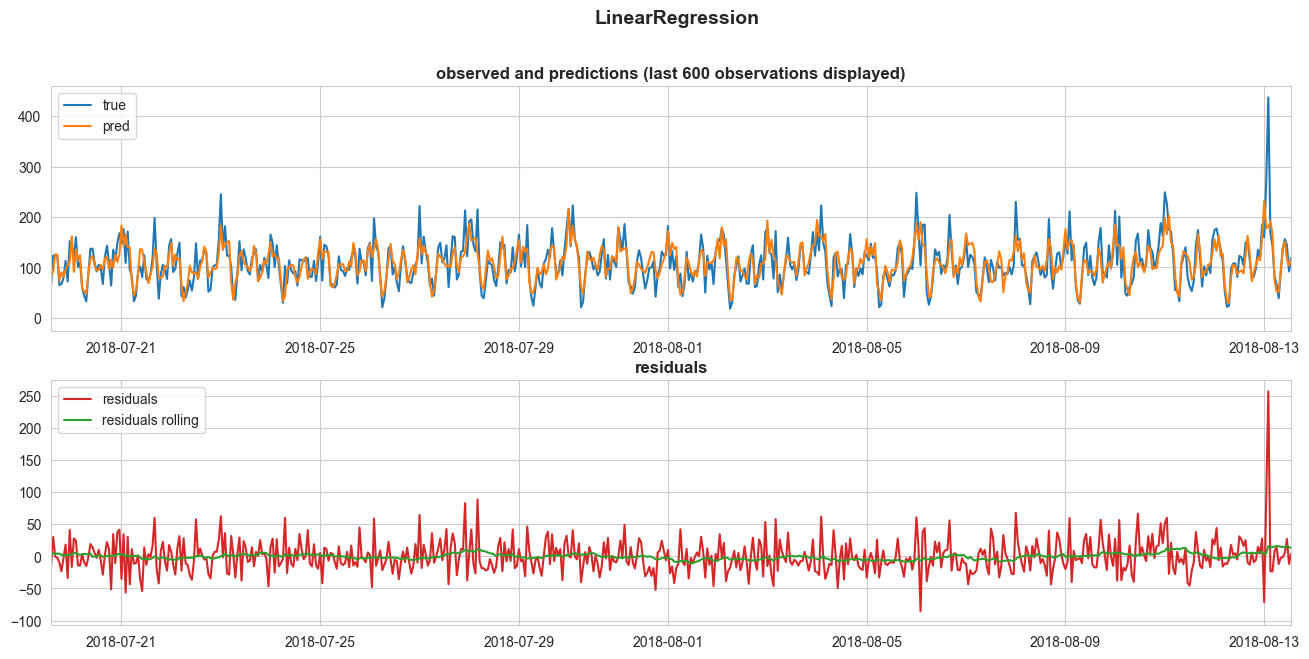

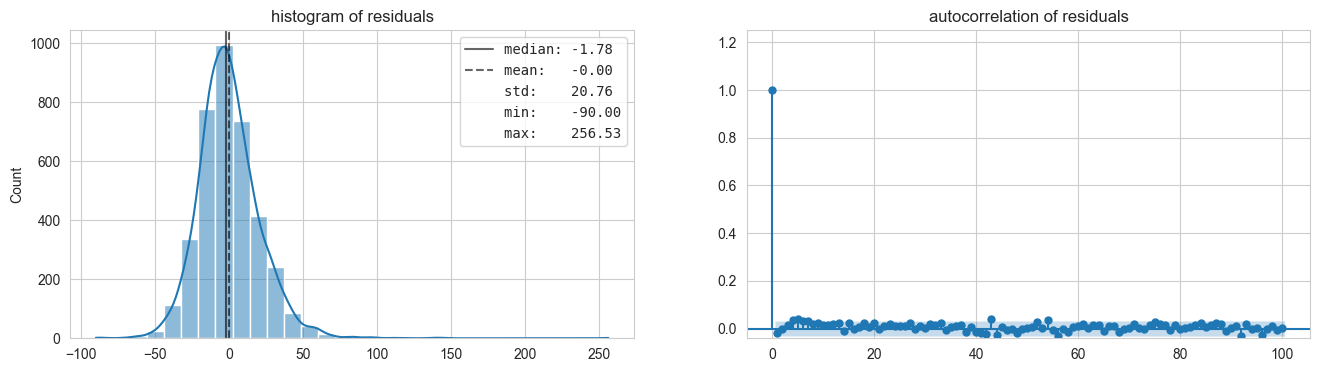

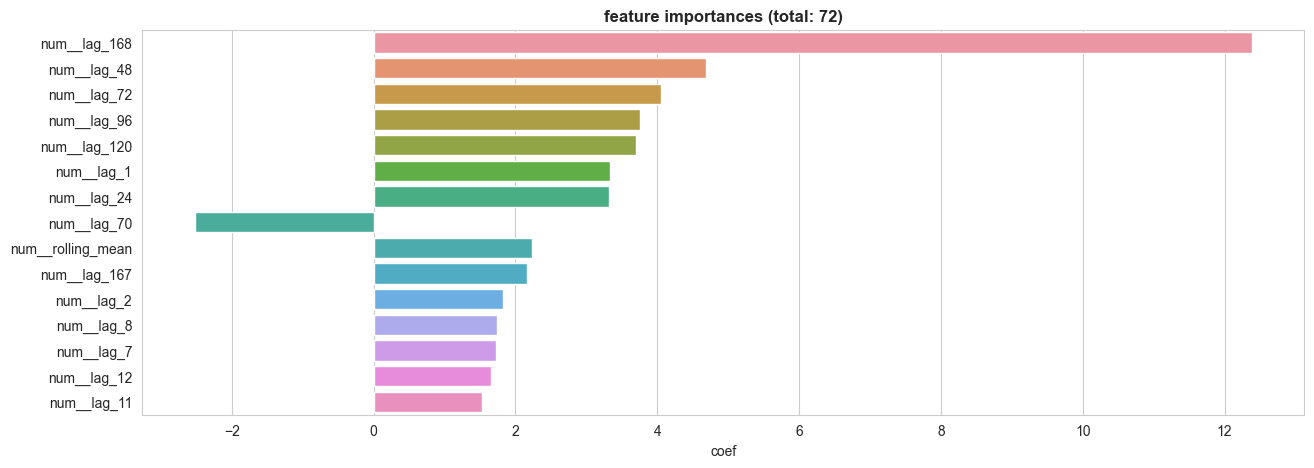

In [45]:
# Список параметров
param_distributions = {
}

# Подбор параметров
optuna_search_lr = optuna_search_cv(
    LinearRegression(), 
    param_distributions,
    X_train, y_train, n_trials=1)


# Вывод результатов
optuna_result(optuna_search_lr, X_train, y_train)

**Вывод:** на удивление простая линейная регрессия довольно неплохо справилась с задачей. Автокорреляция в остатках присутствует, но незначительная. Среднее значение остатков находится в нуле. А их стандартное отклонение составляет 21.  
Среди признаков с наибольшими коэффициентами лидирует 168 лаг. Т.е. модель в значительной степени опирается на данные, полученные ровно неделю назад.

### **ElasticNet**

Далее опробуем линейную регрессию с регуляризацией. Здесь применим автоподбор параметров из заданных промежутков.

ElasticNet best parameters:
model__alpha: 0.42129303719291866
model__l1_ratio: 0.8297098992968142


Search params (sec) Predict (sec) RMSE (cv) train Residuals mean  \
ElasticNet              3.9152         0.004         21.6413           -0.0   

           Residuals std  
ElasticNet       21.0257

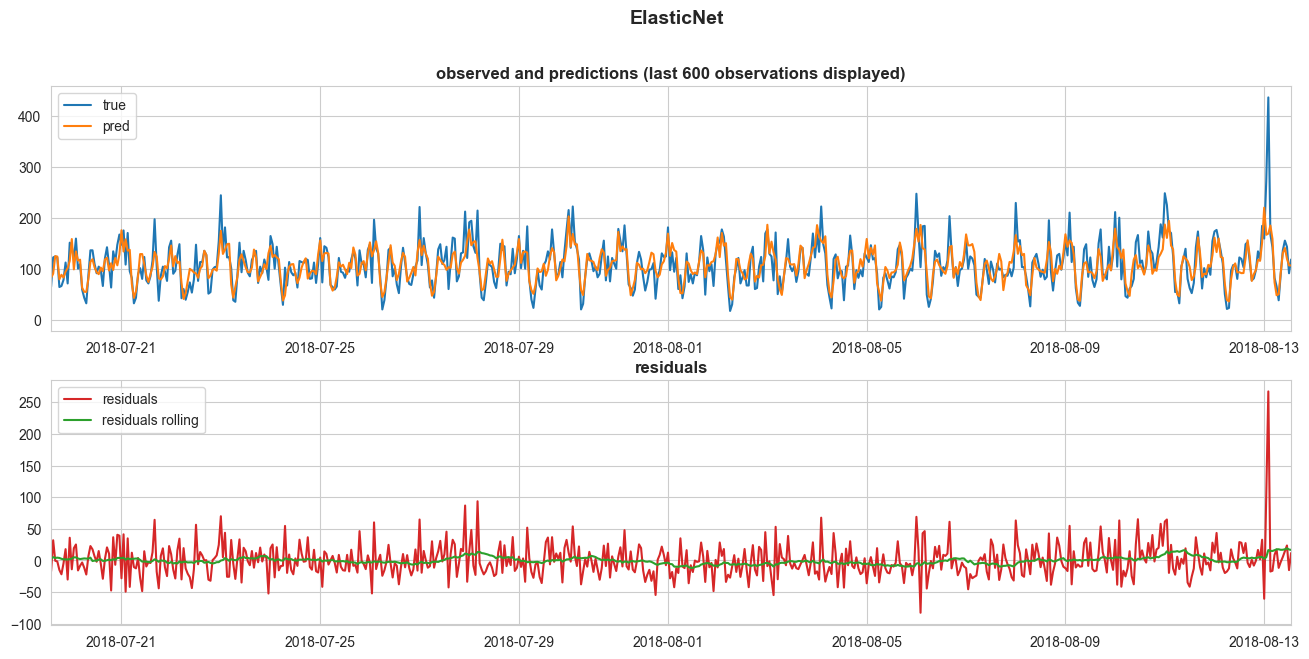

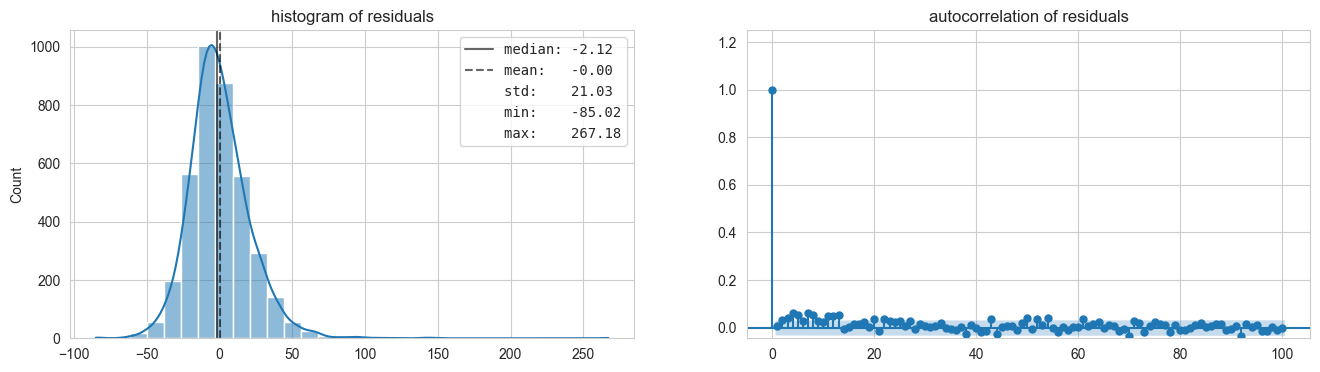

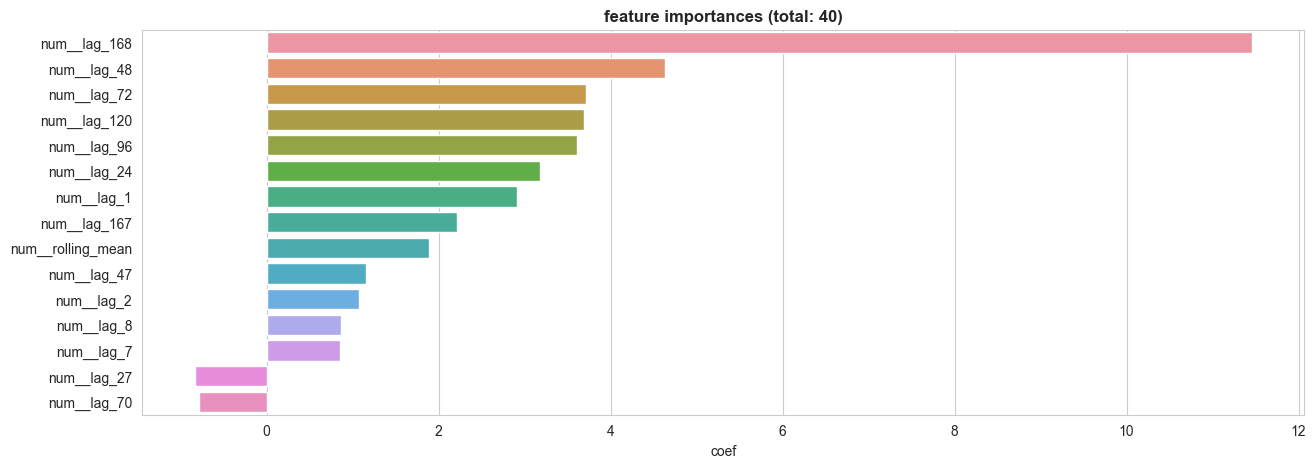

In [46]:
# Список параметров
param_distributions = {
    'model__alpha': opt_dis.FloatDistribution(0, 1),
    'model__l1_ratio': opt_dis.FloatDistribution(0, 1)
}


# Подбор параметров
optuna_search_elastic = optuna_search_cv(
    ElasticNet(random_state=RANDOM_STATE), 
    param_distributions,
    X_train, y_train)


# Вывод результатов
optuna_result(optuna_search_elastic, X_train, y_train)

**Вывод:** по сравнению с простой линейной регрессией качество незначительно подросло - RMSE на кросс-валидации составляет 21.64. Лаг с номром 168 здесь вносит чуть меньший вклад. За счет того, что в модели применена L1 регуляризация, коэффициенты для 32 признаков были обнулены. В остатках наблюдается небольшая автокорреляция в начале графика, что у простой линейной регрессии было не столь выражено.

### **RandomForestRegressor**

RandomForestRegressor best parameters:
model__n_estimators: 18
model__max_depth: 8
model__min_samples_leaf: 10
model__min_samples_split: 13


Search params (sec) Predict (sec) RMSE (cv) train  \
RandomForestRegressor            101.2467         0.008         22.4557   

                      Residuals mean Residuals std  
RandomForestRegressor         0.0708       17.2102

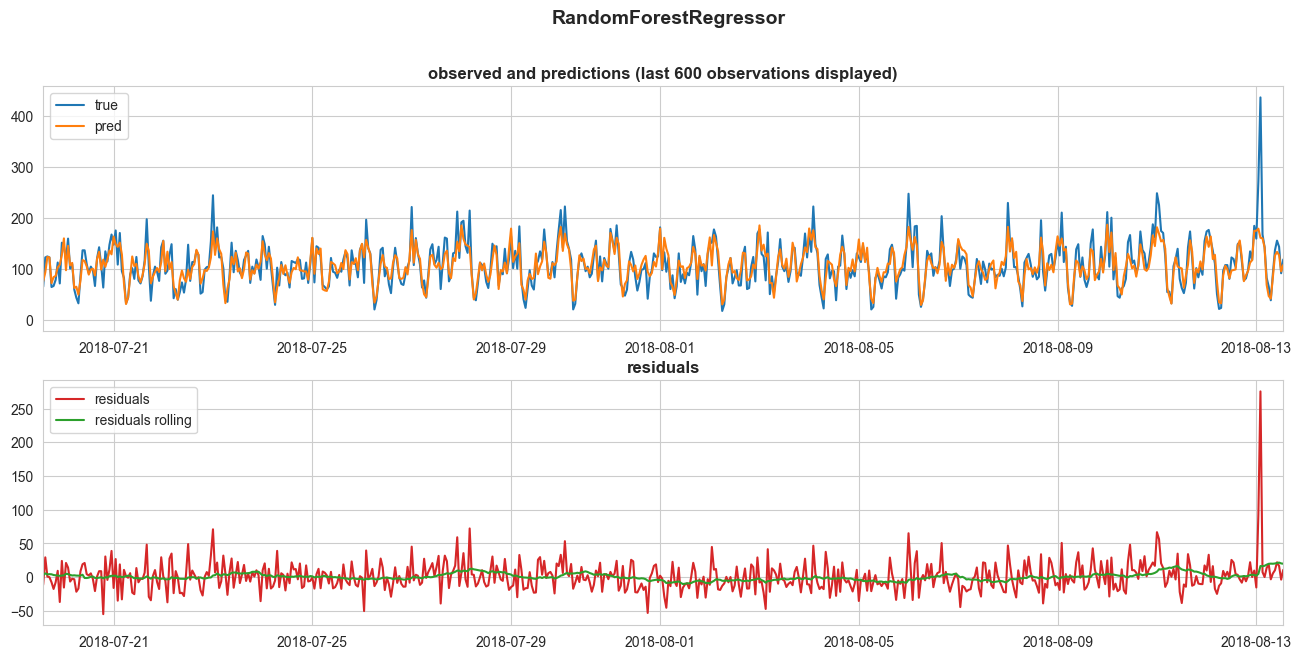

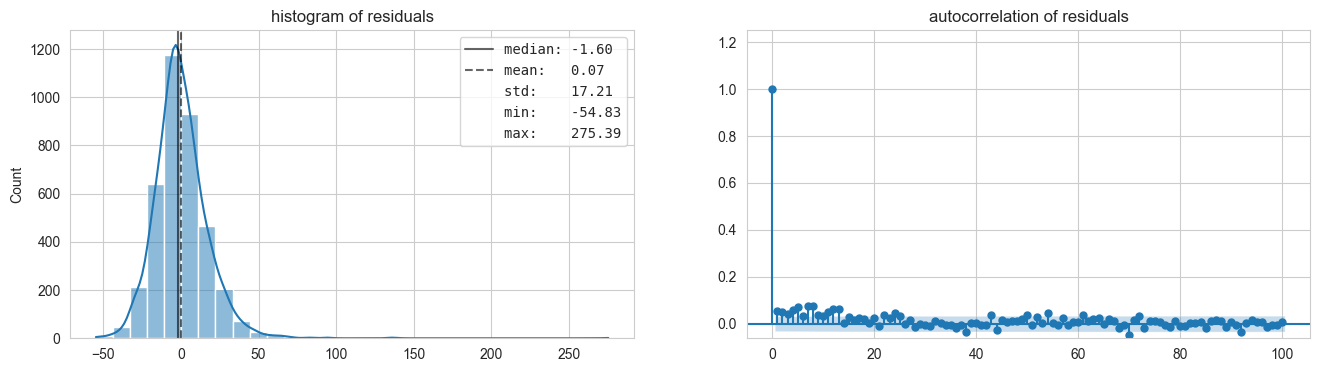

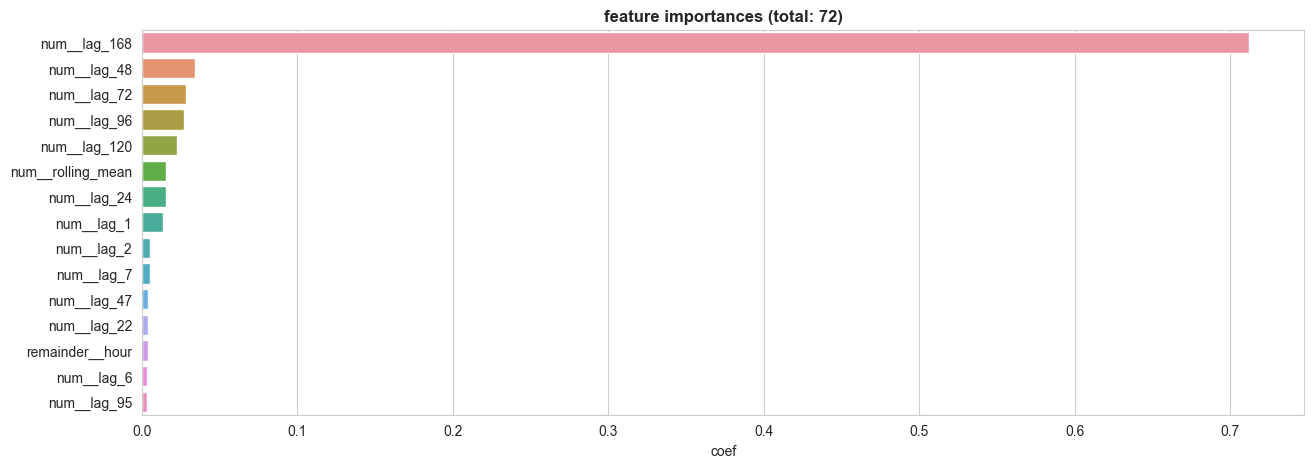

In [47]:
param_distributions = {
    'model__n_estimators': opt_dis.IntDistribution(5, 20),
    'model__max_depth': opt_dis.IntDistribution(2, 15),
    'model__min_samples_leaf': opt_dis.IntDistribution(1, 10),
    'model__min_samples_split': opt_dis.IntDistribution(2, 20)
}


optuna_search_rfr = optuna_search_cv(
    RandomForestRegressor(random_state=RANDOM_STATE), 
    param_distributions,
    X_train, y_train)


optuna_result(optuna_search_rfr, X_train, y_train)

**Вывод:** модель случайного леса слишком переоценила значение 168 лага, по сравнению с другими признаками. Автокорреляция остатков хуже, чем у линейной регрессии, хотя дисперсия остатков несколько уменьшилась.

### **LGBMRegressor**

Далее попробуем несколько моделей из сторонних библиотек с применением градиентного бустинга. Первом моделью будет **LGBMRegressor** из библиотеки **LightGBM**.

LGBMRegressor best parameters:
model__n_estimators: 111
model__reg_alpha: 80.98038463847674
model__reg_lambda: 13.313138511735238


Search params (sec) Predict (sec) RMSE (cv) train  \
LGBMRegressor             19.2703         0.017         22.1606   

              Residuals mean Residuals std  
LGBMRegressor         0.0457         11.25

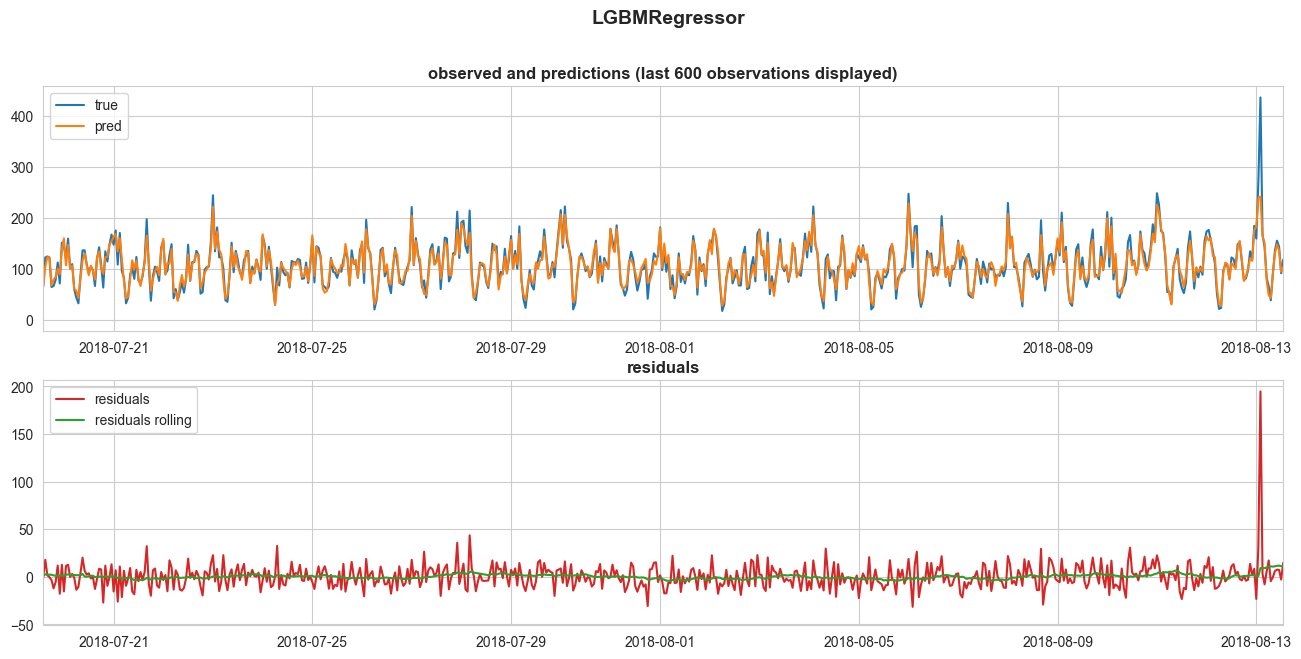

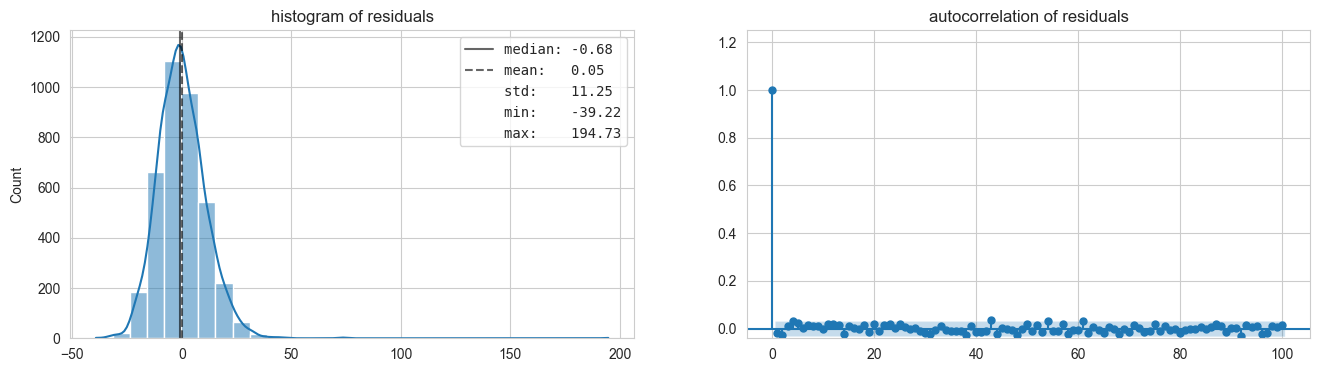

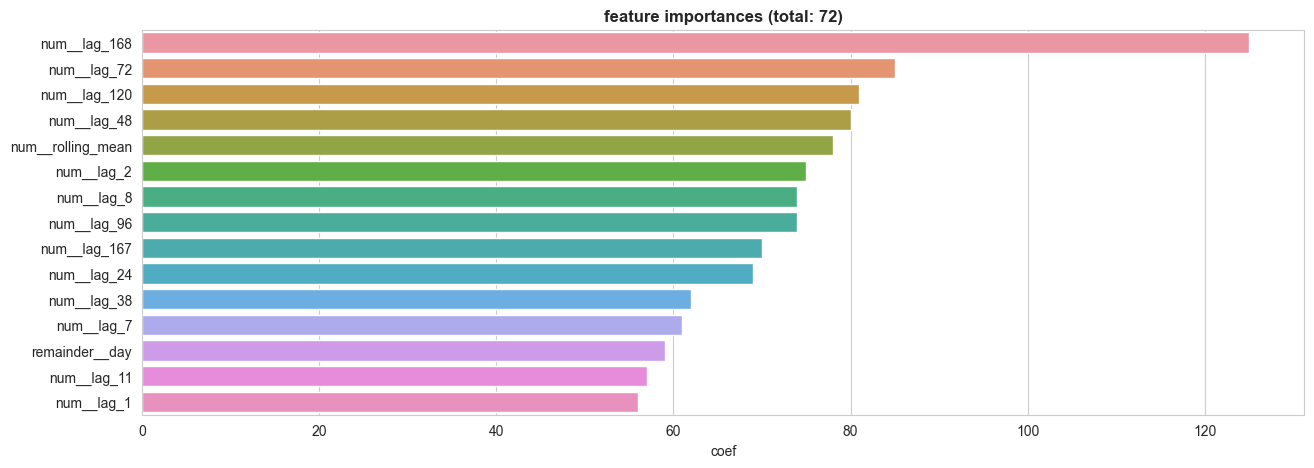

In [48]:
param_distributions = {
    'model__n_estimators': opt_dis.IntDistribution(10, 150),
    'model__reg_alpha': opt_dis.FloatDistribution(50, 100), # L1
    'model__reg_lambda': opt_dis.FloatDistribution(2, 20), # L2
}


optuna_search_lgbmr = optuna_search_cv(
    LGBMRegressor(random_state=RANDOM_STATE, verbose=-1, n_jobs=-1), 
    param_distributions,
    X_train, y_train)


optuna_result(optuna_search_lgbmr, X_train, y_train)

**Вывод:** данная модель хорошо распределила значимость среди признаков. Здесь по прежнему наибольший вклад вносит 168 лаг, но он уже не так сильно перетягивает на себя одеяло, как в других моделях. Стандартное отклонение и автокорреляция остатков здесь самые лучшие из уже протестированных моделей. Так же данная модель лучше всех предсказала выброс в правой части графика.

### **CatBoostRegressor**

CatBoostRegressor best parameters:
model__iterations: 144


Search params (sec) Predict (sec) RMSE (cv) train  \
CatBoostRegressor             85.7517         0.009         22.1193   

                  Residuals mean Residuals std  
CatBoostRegressor         0.0035       11.8912

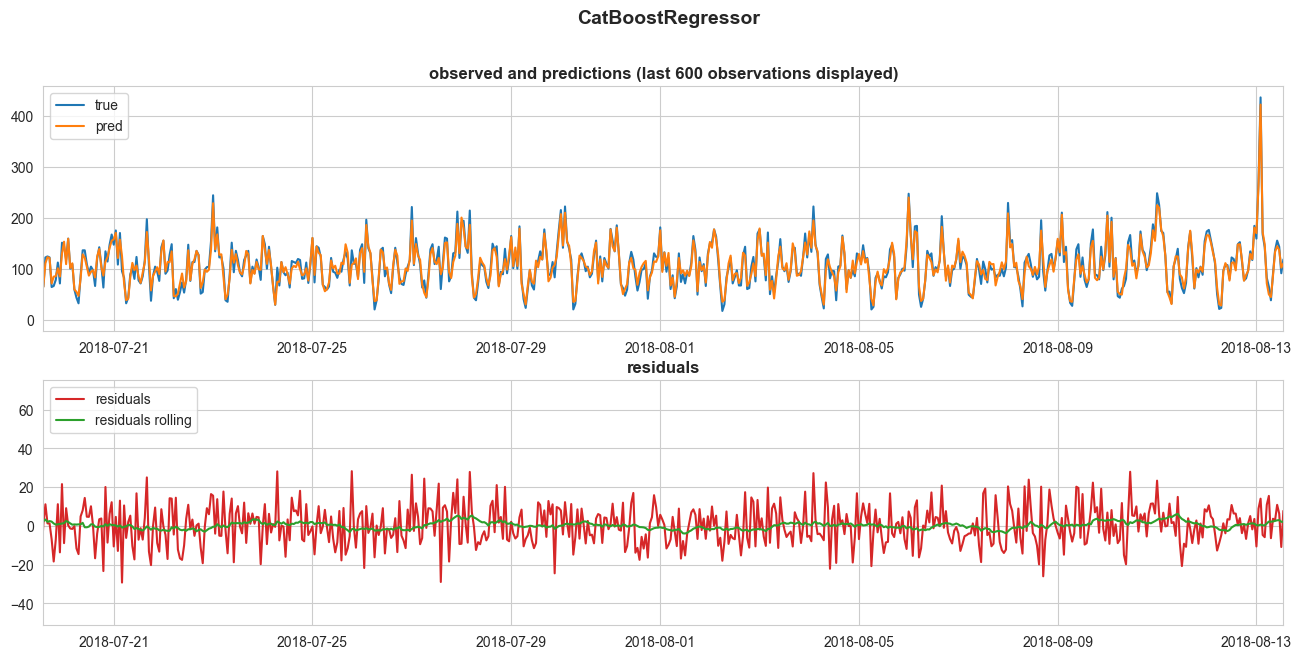

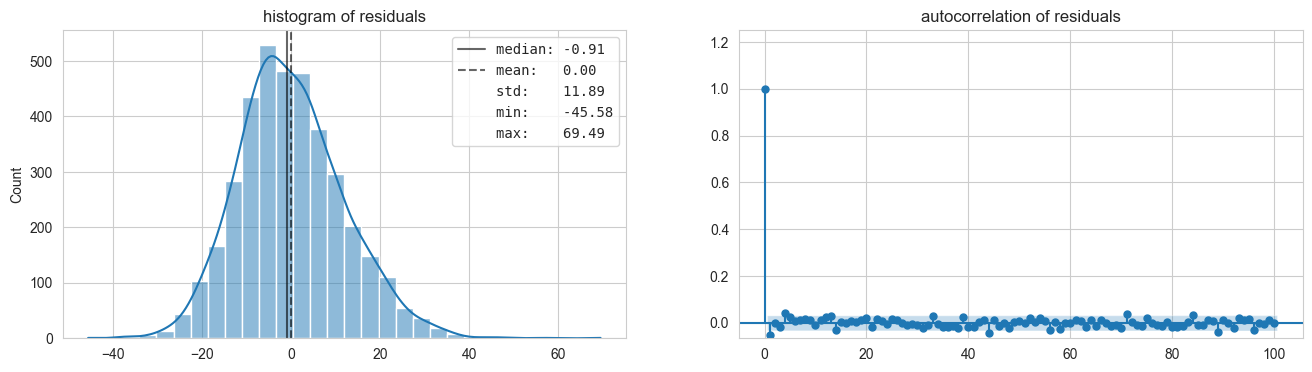

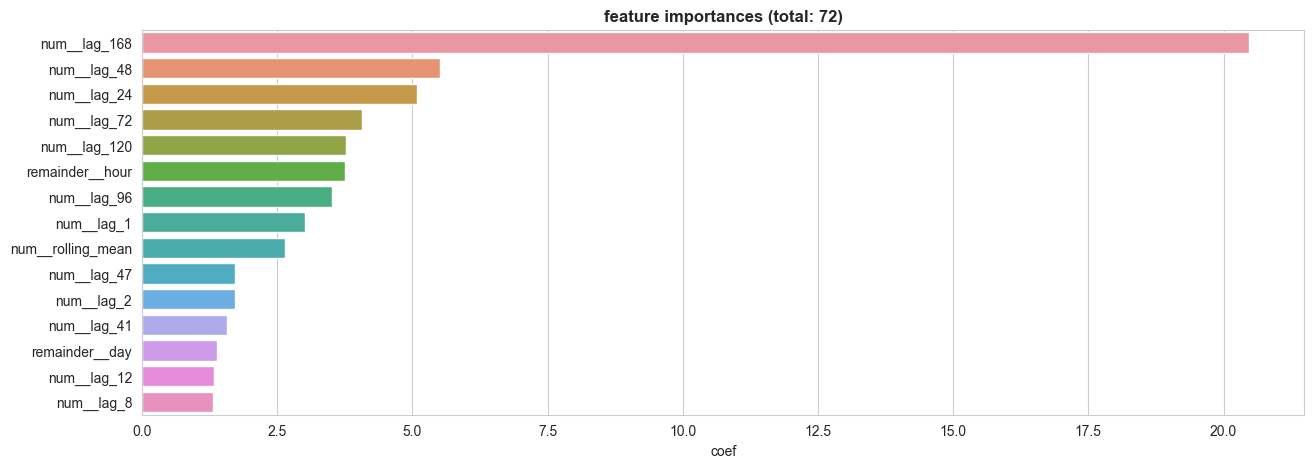

In [49]:
param_distributions = {
    'model__iterations': opt_dis.IntDistribution(10, 200)
}


optuna_search_catbr = optuna_search_cv(
    CatBoostRegressor(random_state=RANDOM_STATE, verbose=0), 
    param_distributions,
    X_train, y_train)


optuna_result(optuna_search_catbr, X_train, y_train)

**Вывод:** модель CatBoost, как и почти все остальные, переоценила вклад 168 лага. Но лучше всех предсказала выброс в правом краю графика, что в данном случае, может свидетельствовать о переобучении.

### **SARIMAX**

В противовес регрессионным моделям применим модель из семейства ARMA, разработанную специально для работы с временными рядами.  
Для подбора гиперпараметров к модели воспользуемся графиками автокорреляции и частичной автокорреляции.

SARIMAX($p,d,q$)x($P,D,Q,s$)

Как мы выяснили, дифференцирование ряда в нашем случае помогает избавиться от нестационарности, поэтому параметр $d=1$. На первом графике автокорреляции мы видим, что существенное влияние на измерение (в масштабе сезона в сутки) оказывает только первый ближайший лаг, поэтому $q=1$ - параметр отвечающий за порядок скользящего среднего. Параметр $p$, описывающий порядок авторегрессии возьмем равным 7, его определим по второму графику частичной автокорреляции, как 7 первых значимых лагов.

Параметры из второй категории отвечают за сезонную составляющую. $s=24$ - длина сезонного периода. $D=0$, так как сезонное дифференцирование мы не используем, потому что для достижения стационарности достаточно обычного.  
Параметры $P$ и $Q$ возьмем равными $2$. Можно было бы взять значения побольше, но тогда расчет модели сильно затягивается и на некоторых комбинациях параметров код выпадает в ошибку.

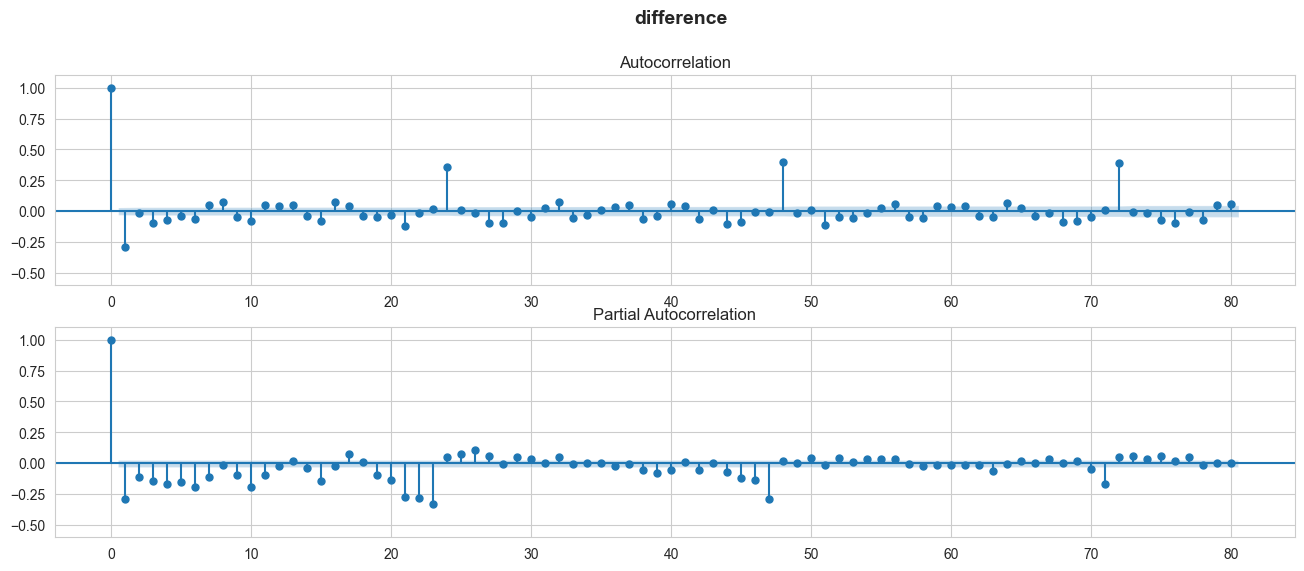

In [50]:
plot_acf_pacf(data['num_orders'].diff().dropna(), title='difference', lags=80, vertical=True)

Выше описан подбор параметров в первом приближении. После небольших тестов остановим свой выбор на таких: SARIMAX($1,1,2$)x($2,0,2,24$).

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3806
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 24)   Log Likelihood              -17187.286
Date:                            Thu, 20 Jun 2024   AIC                          34390.572
Time:                                    18:07:22   BIC                          34440.524
Sample:                                03-08-2018   HQIC                         34408.324
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8263      0.025     32.919      0.000       0.777       0.875
ma.L1         -1.6614      0.029   

Search params (sec) Predict (sec) RMSE (cv) train Residuals mean  \
SARIMAX                 NaN         0.001         22.2549         0.1371   

        Residuals std  
SARIMAX       22.2574

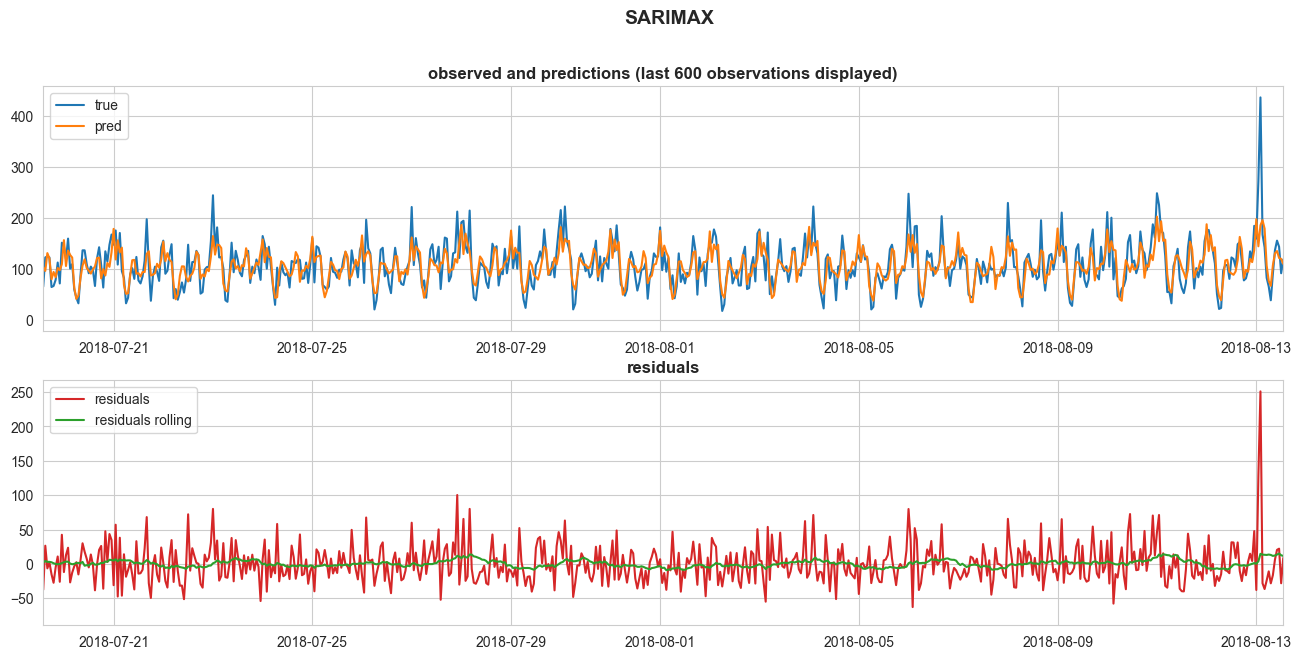

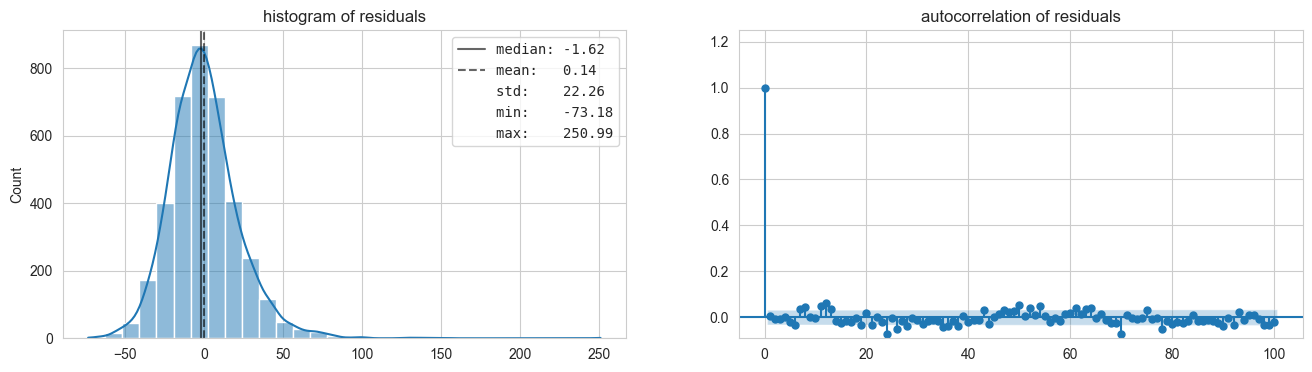

In [51]:
sarimax = SARIMAX(
    y_train, 
    order=(1, 1, 2), 
    seasonal_order=(2, 0, 2, 24)
    ).fit()

print(sarimax.summary())


# Предсказание на тренировочной выборке
start = time.time()
y_pred_sarimax = sarimax.predict(0, len(y_train) - 1)
predict_time = time.time() - start
# Расчет метрики
rmse_train_sarimax = mean_squared_error(y_train, y_pred_sarimax) ** .5
# Подсчет остатков
resid_sarimax = y_train - y_pred_sarimax


# Запись результатов в таблицу
result_sarimax = [np.nan, predict_time, rmse_train_sarimax, resid_sarimax.mean(), resid_sarimax.std()]
rating_model.loc['SARIMAX'] = [round(x, 4) for x in result_sarimax]

display(rating_model.loc[['SARIMAX']])
analysis_results_plot(y_train, y_pred_sarimax, title='SARIMAX', view_last_segment=600)

**Вывод:** по сравнение с регрессионными моделями удалось добиться только среднего качества. В остатках наблюдается небольшая автокорреляция.

## Анализ моделей

Рассмотрим сводную таблицу, отсортировав по убыванию метрики качества **RMSE**

In [52]:
rating_model.sort_values(by='RMSE (cv) train')

Search params (sec) Predict (sec) RMSE (cv) train  \
ElasticNet                         3.9152         0.004         21.6413   
LinearRegression                   0.1687         0.004         21.9532   
CatBoostRegressor                 85.7517         0.009         22.1193   
LGBMRegressor                     19.2703         0.017         22.1606   
SARIMAX                               NaN         0.001         22.2549   
RandomForestRegressor            101.2467         0.008         22.4557   
DummyRegressor                     0.0861         0.003         39.4822   

                      Residuals mean Residuals std  
ElasticNet                      -0.0       21.0257  
LinearRegression                -0.0       20.7566  
CatBoostRegressor             0.0035       11.8912  
LGBMRegressor                 0.0457         11.25  
SARIMAX                       0.1371       22.2574  
RandomForestRegressor         0.0708       17.2102  
DummyRegressor                  -0.0       38.6833

Лучшей по метрике RMSE на кросс-валидации является модель **ElasticNet**, но по совокупности факторов в качестве лучшей модели я бы выбрал **LGBMRegressor**, так как у нее значимость признаков распределена наиболее равномерно. Стандартное отклонение остатков у нее самое низкое. Автокорреляция остатков у нее так же наименее выражена, а метрика отличается от лидера только на 0.5.  
Оценим работу модели **LGBMRegressor** на тестовой выборке.

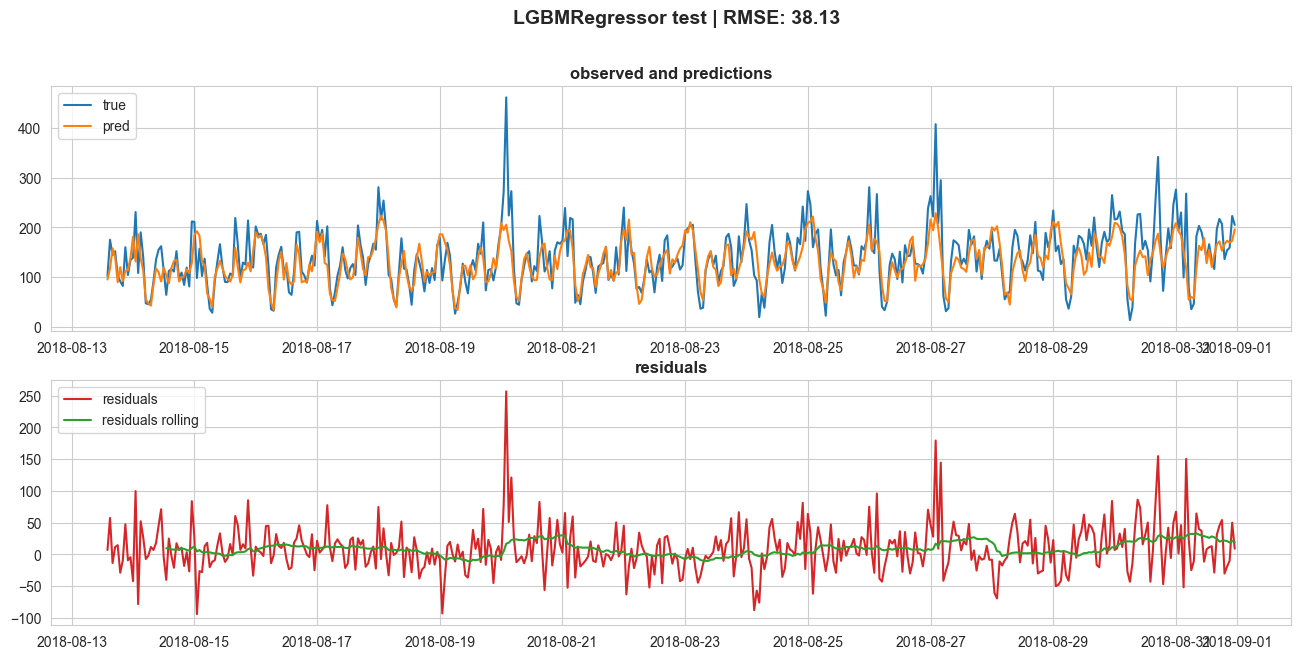

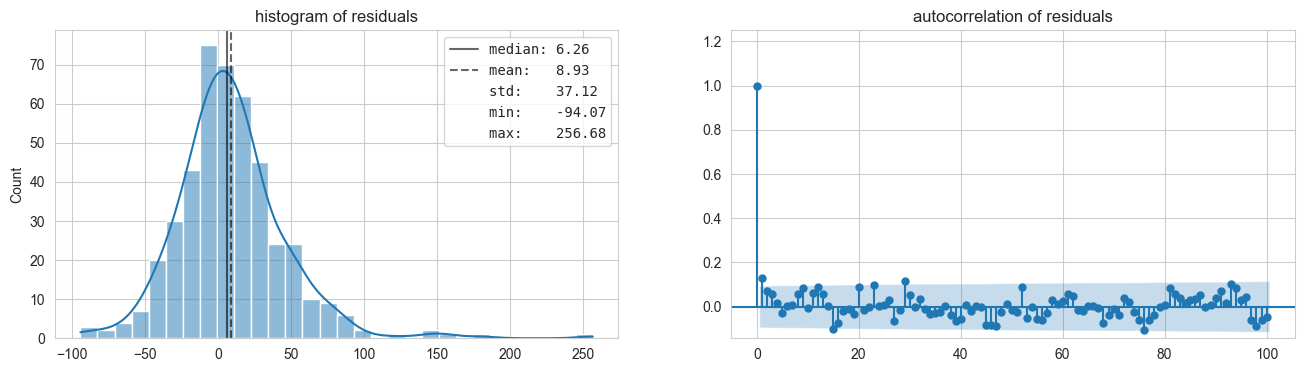

In [53]:
y_pred_lgbmr = pd.Series(
    optuna_search_lgbmr.predict(X_test), 
    index=X_test.index
)

rmse_lgbmr = mean_squared_error(y_test, y_pred_lgbmr) ** .5
analysis_results_plot(y_test, y_pred_lgbmr, title=f'LGBMRegressor test | RMSE: {rmse_lgbmr:.2f}')

**Вывод:** Качество предсказаний на тесте довольно неплохое - **RMSE = 38.13**, что перекрывает требования задачи в **48**. Качество остатков упало по сравнению с тренировочной выборкой - на гистограмме появилось смещение вправо. Т.е. модель чаще занижает предсказания, относительно реальности.

Так же отдельно протестируем модель SARIMAX, так как она работает принципиально по другому. Если модели регрессии при предсказании следующего шага "видят" реальное значение шаг назад (так как в качестве признаков мы используем лаги). То модели ARMA при прогнозировании на несколько тактов вперед не получают на вход реальных значений шаг назад, они строят прогноз, пытаясь описать весь ряд математической формулой. При предсказании на вход модели передается только начало и конец прогнозируемого промежутка.

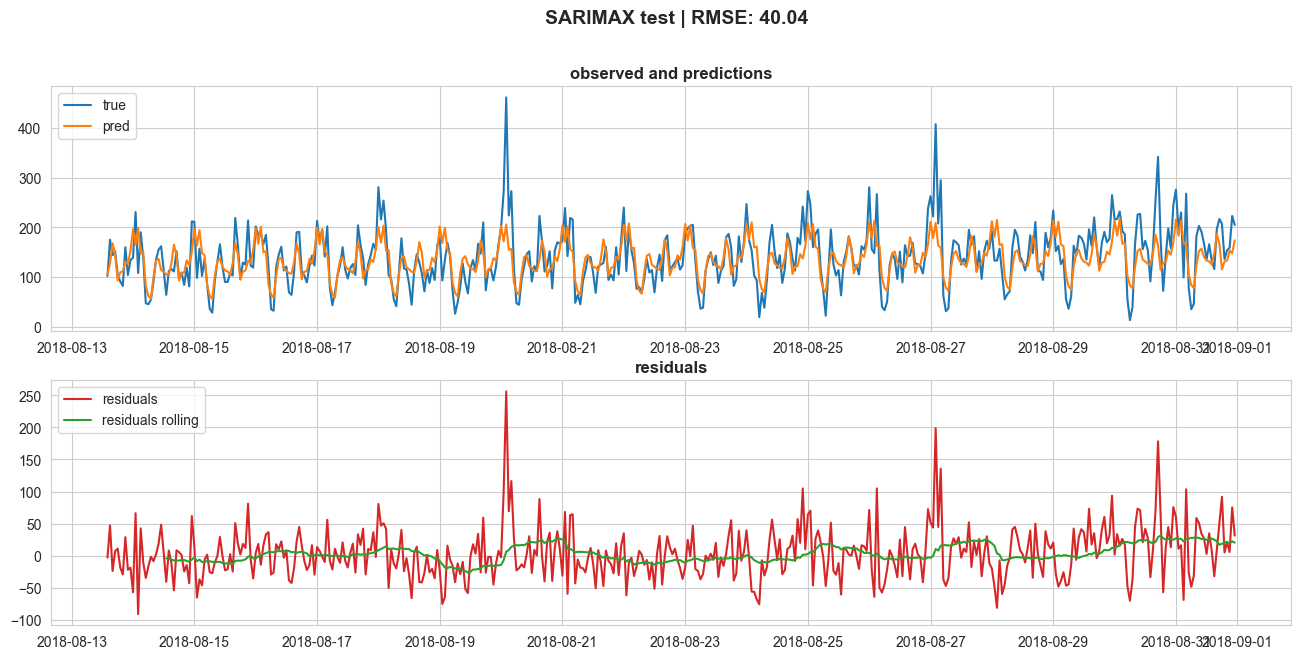

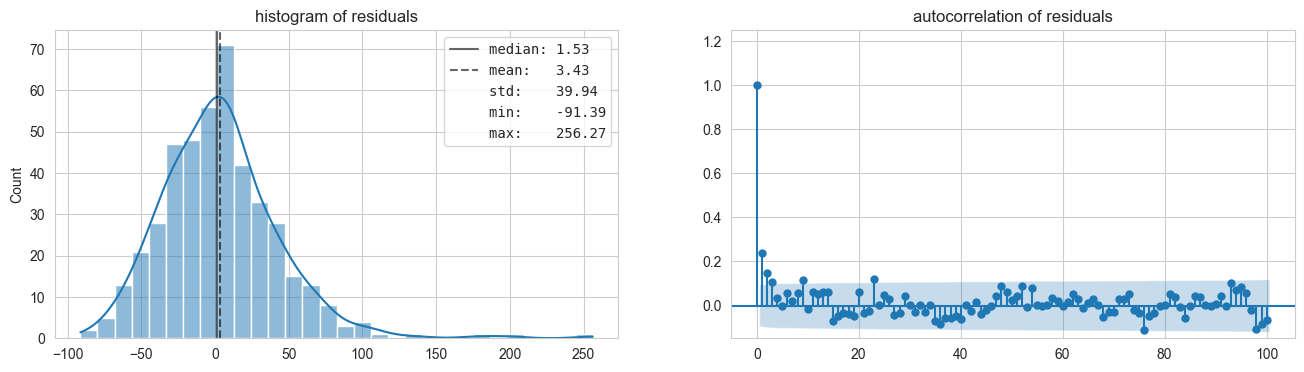

In [54]:
y_pred_sarimax = sarimax.predict(y_test.index[0], y_test.index[-1])
# y_pred_sarimax = sarimax.predict(len(y_train), len(y_train) + len(y_test) - 1)

rmse_sarimax = mean_squared_error(y_test, y_pred_sarimax) ** .5
analysis_results_plot(y_test, y_pred_sarimax, title=f'SARIMAX test | RMSE: {rmse_sarimax:.2f}')

Учитывая вышесказанное, модель SARIMA справилась довольно неплохо, смещение в остатках получилось даже меньше, чем у LGBMRegressor.  
При построении прогнозов с помощью регрессионных моделей больше чем на 1 шаг вперед, если тестовых данных у нас нет, в качестве лагов уже бы брались предыдущие предсказания. В таком случае ошибка постепенно будет накапливаться. И при таком сценарии использования метрика качества может оказаться даже хуже чем у SARIMAX. Но в рамках нашей задачи необходимо делать прогноз лишь на шаг вперед.

## Общий вывод

Условие нашей задачи следующее: *Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.*  
Для этой цели отлично подойдет регрессионная модель **LGBMRegressor** из библиотеки **LightGBM** со следующими гиперпараметрами:  
`n_estimators: 111`  
`reg_alpha: 80.98`  
`reg_lambda: 13.31`  
Метрика на тестовой выборке **RMSE = 38.13**, что допускается требованиями, предъявленными заказчиком. Данный класс моделей просто и быстро дообучить, в отличии от ARMA.

Если бы горизонт прогнозирования был больше, то можно было бы присмотреться к моделям класса ARMA, но они более трудоемки в настройке. И при больших значениях гиперпараметров долго обучаются.